In [1]:
import sys

import numpy as np
import pandas as pd

import time
from datetime import datetime, timedelta

from operator import itemgetter
from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', 80) 

In [2]:
from IPython.display import clear_output

In [3]:
df_1 = pd.read_csv('data/train.csv', sep=',', encoding='utf-8')
df_1["channel_type"].fillna(u"type0", inplace=True)
df_1.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,type0,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,type0,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,type0,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,type0,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,type0,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


In [4]:
Counter(df_1["channel_type"])

Counter({u'type0': 2910,
         u'type1': 299247,
         u'type2': 175013,
         u'type3': 3280,
         u'type4': 4476,
         u'type5': 5587})

In [5]:
df_2 = pd.read_csv('data/test.csv', sep=',', encoding='utf-8')
df_2["channel_type"].fillna(u"type0", inplace=True)
df_2.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category
0,01/04/2017,2,5814,type0,810,18APR17:00:00:00,153.00,POS
1,01/03/2017,2,5812,type0,810,10MAR17:00:00:00,388.08,POS
2,01/02/2017,2,5691,type0,810,21FEB17:00:00:00,999.00,POS
3,01/04/2017,2,5814,type0,810,26APR17:00:00:00,90.00,POS
4,01/04/2017,2,5814,type0,810,08APR17:00:00:00,130.00,POS


In [6]:
Counter(df_2["channel_type"])

Counter({u'type0': 2154,
         u'type1': 320509,
         u'type2': 182058,
         u'type3': 4565,
         u'type4': 5009,
         u'type5': 4081})

In [7]:
df = pd.concat([df_1, df_2], axis=0, sort=["cl_id", "TRDATETIME"])

# Отбрасываем время транзакции
df["TRDATETIME"] = df["TRDATETIME"].apply(
    lambda t: datetime.strptime(t, '%d%b%y:%H:%M:%S').strftime('%Y-%m-%d'))

# Объединяем категории валюты: 643 и 810
df.loc[df["currency"] == 643, "currency"] = 810

df.columns = map(lambda s: s.lower(), df.columns)
df["channel_type"] = df["channel_type"].astype('category').cat.codes
df.head()

,mcc,period,trdatetime,amount,channel_type,cl_id,currency,target_flag,target_sum,trx_category
0,5200,01/10/2017,2017-10-21,5023.0,0,0,810,0.0,0.0,POS
1,6011,01/10/2017,2017-10-12,20000.0,0,0,810,0.0,0.0,DEPOSIT
2,5921,01/12/2017,2017-12-05,767.0,0,0,810,0.0,0.0,POS
3,5411,01/10/2017,2017-10-21,2031.0,0,0,810,0.0,0.0,POS
4,6012,01/10/2017,2017-10-24,36562.0,0,0,810,0.0,0.0,C2C_OUT


### Добавляем информацию о MCC-кодах

In [8]:
df_mcc_codes = pd.read_csv('mcc_codes_ru.csv', sep=',', encoding='utf-8')
df_mcc_codes.rename(columns={
        u'MCC': 'mcc',
        u'Название': 'name',
        u'Группа': 'mcc_group',
        u'Обновлено': 'updated'}, inplace=True)
df_mcc_codes.drop('updated', axis=1, inplace=True)
df_mcc_codes['mcc_group'] = df_mcc_codes['mcc_group'].astype('category').cat.codes + 1
df_mcc_codes.head()

,mcc,name,mcc_group
0,742,Ветеринарные услуги,7
1,763,Сельскохозяйственные кооперативы,7
2,780,Услуги садоводства и ландшафтного дизайна,7
3,1520,Генеральные подрядчики – жилое и коммерческое ...,7
4,1711,"Генеральные подрядчики по вентиляции, теплосна...",7


In [9]:
df_mcc_codes['mcc_group'].unique()

array([ 7, 10,  1,  3, 11, 19,  0,  6, 12, 18,  2,  9, 16, 13,  8,  4, 17,
       15, 14, 20,  5])

In [10]:
df = pd.merge(df, df_mcc_codes[['mcc', 'mcc_group']], on="mcc")
df.head()

,mcc,period,trdatetime,amount,channel_type,cl_id,currency,target_flag,target_sum,trx_category,mcc_group
0,5200,01/10/2017,2017-10-21,5023.0,0,0,810,0.0,0.0,POS,18
1,5200,01/09/2017,2017-09-30,23.9,0,1,978,0.0,0.0,POS,18
2,5200,01/09/2017,2017-09-17,707.2,0,10,810,0.0,0.0,POS,18
3,5200,01/07/2017,2017-07-16,65.6,0,10,810,0.0,0.0,POS,18
4,5200,01/07/2017,2017-07-16,205.0,0,10,810,0.0,0.0,POS,18


### Добавляем информацию о праздниках

In [11]:
holidays = {
    # На основе: http://calendar.yoip.ru/holiday/2016-calendar-prazdnikov.html
    '2016-09-01': {'holiday'},  # День знаний
    '2016-10-05': {'holiday'},  # День учителя
    '2016-11-03': {'short'},
    '2016-11-04': {'holiday', 'dayoff'}, # holiday ?
    '2016-11-25': {'holiday'},  # Черная пятница
    '2016-12-31': {'holiday', 'dayoff'},
    
    # На основе: http://calendar.yoip.ru/holiday/2017-calendar-prazdnikov.html
    '2017-01-01': {'holiday', 'dayoff'},
    '2017-01-02': {'dayoff'},
    '2017-01-03': {'dayoff'},
    '2017-01-04': {'dayoff'},
    '2017-01-05': {'dayoff'},
    '2017-01-06': {'dayoff'},
    '2017-01-07': {'holiday', 'dayoff'},
    '2017-02-14': {'holiday'}, # День св. Валентина
    '2017-02-22': {'short'},
    '2017-02-23': {'holiday', 'dayoff'},
    '2017-02-24': {'dayoff'},
    '2017-03-07': {'short'},
    '2017-03-08': {'holiday', 'dayoff'},
    '2017-05-01': {'holiday', 'dayoff'},
    '2017-05-08': {'dayoff'},
    '2017-05-09': {'holiday', 'dayoff'},
    '2017-06-12': {'holiday', 'dayoff'}, # holiday ?
    '2017-09-01': {'holiday'},  # День знаний
    '2017-10-05': {'holiday'},  # День учителя
    '2017-11-03': {'short'},
    '2017-11-04': {'holiday', 'dayoff'}, # holiday ?
    '2017-11-06': {'dayoff'},
    '2017-11-24': {'holiday'},  # Черная пятница
    '2017-12-31': {'holiday', 'dayoff'},

    # На основе: http://calendar.yoip.ru/holiday/2018-calendar-prazdnikov.html
    '2018-01-01': {'holiday', 'dayoff'},
    '2018-01-02': {'dayoff'},
    '2018-01-03': {'dayoff'},
    '2018-01-04': {'dayoff'},
    '2018-01-05': {'dayoff'},
    '2018-01-06': {'dayoff'},
    '2018-01-07': {'holiday', 'dayoff'},
    '2018-01-08': {'dayoff'},
    '2018-02-14': {'holiday'}, # День св. Валентина
    '2018-02-22': {'short'},
    '2018-02-23': {'holiday', 'dayoff'},
    '2018-03-07': {'short'},
    '2018-03-08': {'holiday', 'dayoff'},
    '2018-03-09': {'dayoff'},
    '2018-04-28': {'short'},
    '2018-05-01': {'holiday', 'dayoff'},
    '2018-05-02': {'dayoff'},
    '2018-05-08': {'short'},
    '2018-05-09': {'holiday', 'dayoff'},
    '2018-06-09': {'short'},
    '2018-06-11': {'dayoff'},
    '2018-06-12': {'holiday', 'dayoff'}, # holiday ?
    '2018-09-01': {'holiday'},  # День знаний
    '2018-10-05': {'holiday'},  # День учителя
    '2018-11-03': {'short'},
    '2018-11-04': {'holiday', 'dayoff'}, # holiday ?
    '2018-11-04': {'dayoff'},
    '2018-11-23': {'holiday'},  # Черная пятница
    '2018-12-29': {'short'},
    '2018-12-31': {'holiday', 'dayoff'},
}

holidays_set = sorted([
        datetime.strptime(d, '%Y-%m-%d')
        for d, s in holidays.iteritems() if 'holiday' in s
    ])

In [12]:
def get_features_from_date(date_str):
    date_dt = datetime.strptime(date_str, '%Y-%m-%d')
    
    date_features = {
        'trx_datetime': date_dt,
        'trdatetime':   date_str,
        'is_weekend':   date_dt.isoweekday() > 5,
        'wday':         date_dt.isoweekday(),
        'yweek':        date_dt.isocalendar()[1],
        'yday':         date_dt.timetuple().tm_yday,
        'mday':         date_dt.day,
        'ymonth':       date_dt.month,
        'year':         date_dt.year,
        'yquarter':     (date_dt.month - 1) / 4,
        # 'timestamp':    time.mktime(date_dt.timetuple()),
    }
    
    if date_str not in holidays:
        date_features['is_holiday'] = False
        date_features['is_dayoff']  = False
        date_features['is_short']   = False
    else:
        date_features['is_holiday'] = 'holiday' in holidays[date_str]
        date_features['is_dayoff']  = 'dayoff'  in holidays[date_str]
        date_features['is_short']   = 'short'   in holidays[date_str]
        
    date_dst = [(date_dt - date_h).days for date_h in holidays_set]
    date_features['days_before_holiday'] = np.abs(np.max(filter(lambda x: x <= 0, date_dst)))
    date_features['days_after_holiday'] = np.min(filter(lambda x: x >= 0, date_dst))
        
    return date_features

In [13]:
date_uniq = sorted(df["trdatetime"].unique())

df_dates = pd.DataFrame(map(get_features_from_date, date_uniq))
df_dates.head()

,days_after_holiday,days_before_holiday,is_dayoff,is_holiday,is_short,is_weekend,mday,trdatetime,trx_datetime,wday,yday,year,ymonth,yquarter,yweek
0,2,28,False,False,False,False,7,2016-10-07,2016-10-07,5,281,2016,10,2,40
1,3,27,False,False,False,True,8,2016-10-08,2016-10-08,6,282,2016,10,2,40
2,4,26,False,False,False,True,9,2016-10-09,2016-10-09,7,283,2016,10,2,40
3,5,25,False,False,False,False,10,2016-10-10,2016-10-10,1,284,2016,10,2,41
4,6,24,False,False,False,False,11,2016-10-11,2016-10-11,2,285,2016,10,2,41


In [14]:
df_dates_uniq = {row.trdatetime: dict(row) for dt, row in df_dates.iterrows()}

In [15]:
df = pd.merge(df, df_dates, on="trdatetime")
df.head()

,mcc,period,trdatetime,amount,channel_type,cl_id,currency,target_flag,target_sum,trx_category,mcc_group,days_after_holiday,days_before_holiday,is_dayoff,is_holiday,is_short,is_weekend,mday,trx_datetime,wday,yday,year,ymonth,yquarter,yweek
0,5200,01/10/2017,2017-10-21,5023.00,0,0,810,0.0,0.00,POS,18,16,14,False,False,False,True,21,2017-10-21,6,294,2017,10,2,42
1,5200,01/10/2017,2017-10-21,174.42,1,4563,810,1.0,143265.06,POS,18,16,14,False,False,False,True,21,2017-10-21,6,294,2017,10,2,42
2,5200,01/10/2017,2017-10-21,2951.00,1,4882,810,1.0,152032.10,POS,18,16,14,False,False,False,True,21,2017-10-21,6,294,2017,10,2,42
3,6011,01/10/2017,2017-10-21,1000.00,2,459,810,1.0,74375.21,WD_ATM_OTHER,12,16,14,False,False,False,True,21,2017-10-21,6,294,2017,10,2,42
4,6011,01/10/2017,2017-10-21,20000.00,2,459,810,1.0,74375.21,WD_ATM_OTHER,12,16,14,False,False,False,True,21,2017-10-21,6,294,2017,10,2,42


### Конвертируем валюту

In [16]:
import requests

import xml.etree.ElementTree as ET
import xml.etree.cElementTree as cET

from tqdm import tqdm

date_currencies = dict()

for d in tqdm(df['trdatetime'].unique()):   
    date_req = '{}-{}-{}'.format(d[8:], d[5:7], d[:4])
    
    url_id = 'http://www.cbr.ru/scripts/XML_daily.asp?date_req={}'.format(date_req)
    b = requests.get(url_id)
    if not b.ok:
        print 'Error: ', url_id

    parser = ET.XMLParser(encoding='windows-1251')
    root = ET.fromstring(b.content, parser=parser)
    
    curr = dict()
    for valute in root.iter('Valute'):
        code = int(valute.find('NumCode').text)
        mult = float(valute.find('Value').text.replace(',', '.'))
        curr[code] = mult
    date_currencies[d] = curr

100%|██████████| 543/543 [00:18<00:00, 28.89it/s]


In [17]:
curr_set = set(curr.keys())

In [18]:
set(df["currency"].unique()).difference(curr_set)

{32,
 44,
 48,
 144,
 170,
 188,
 191,
 214,
 344,
 352,
 360,
 376,
 404,
 446,
 458,
 462,
 480,
 484,
 496,
 504,
 516,
 524,
 554,
 604,
 608,
 634,
 690,
 704,
 764,
 784,
 788,
 800,
 810,
 901,
 941,
 977,
 981}

In [19]:
def modify_amount_by_currency(x):
    if x["currency"] == 810 or x["currency"] not in curr_set:
        amount = x["amount"]
    else:
        amount = x["amount"] * date_currencies[x["trdatetime"]][x["currency"]]
    return amount

df["amount"] = df.apply(modify_amount_by_currency, axis=1)

In [20]:
df["amount_log"] = np.log(1.0 + df["amount"])

### Находим особые MCC-категории

In [21]:
def func(df):
    counter = Counter()
    df_users = df.groupby("cl_id")
    for cl_id, group in df_users:
        if group.shape[0] < 15:
            continue
        counter += Counter(group["mcc"])
    n_sum = float(sum(counter.values()))
    for k, v in counter.iteritems():
        counter[k] = v / n_sum
    
    counter_ = {-1: 0}
    for k, v in counter.iteritems():
        if v < 0.005:
            counter_[-1] += v
        else:
            counter_[k] = v
    return counter_

df_tmp = df[["mcc", "channel_type", "target_flag", "cl_id"]]
df_tmp = df_tmp.groupby(["channel_type", "target_flag"]).apply(lambda d: func(d))
df_tmp

channel_type  target_flag
0             0.0            {5651: 0.00621118012422, 5912: 0.0335403726708...
              1.0            {5641: 0.0103174603175, 4111: 0.0198412698413,...
1             0.0            {5641: 0.00624122000825, 5261: 0.0125802866908...
              1.0            {5641: 0.00535720140323, 5261: 0.0093373987738...
2             0.0            {5641: 0.00684327855254, 5261: 0.0091762144227...
              1.0            {5261: 0.00739049682712, 4111: 0.0101699943249...
3             0.0            {5261: 0.00846560846561, 5651: 0.0052910052910...
              1.0            {5511: 0.00531914893617, 5261: 0.0088652482269...
4             0.0            {7941: 0.00594648166501, 5641: 0.0089197224975...
              1.0            {5641: 0.0105078809107, 5261: 0.0131348511384,...
5             0.0            {5641: 0.0131904369332, 5261: 0.0263808738664,...
              1.0            {5261: 0.0259139287367, 4111: 0.0138824618232,...
dtype: object

In [22]:
specified_cats = set()

cats_entries = Counter(df["channel_type"])

for channel_type in range(6):
    tf0, tf1 = dict(), dict()

    for k, v in df_tmp.loc[channel_type, 0.0].iteritems():
        tf0[k] = tf0.get(k, 0) + v
        tf1[k] = tf1.get(k, 0) + 0

    for k, v in df_tmp.loc[channel_type, 1.0].iteritems():
        tf0[k] = tf0.get(k, 0) + 0
        tf1[k] = tf1.get(k, 0) + v
    
    for k, v in tf0.iteritems():
        if v == 0:
            tf1[-1] += tf1[k]
            tf1[k] = 0
        
    for k, v in tf1.iteritems():
        if v == 0:
            tf0[-1] += tf0[k]
            tf0[k] = 0
        
    tf0.pop(-1)
    tf1.pop(-1)
        
    tf0 = {k: v for k, v in tf0.iteritems() if v > 0}
    tf1 = {k: v for k, v in tf1.iteritems() if v > 0}

    for k in sorted(tf0.keys()):
        if cats_entries[channel_type] > 10000 and np.abs(tf0[k] - tf1[k]) > 0.001 or \
                np.abs(tf0[k] - tf1[k]) > 0.01:
            # print "{}\t{:4}\t{:.4f}\t{:.4f}".format(channel_type, k, tf0[k], tf1[k])
            specified_cats.add(k)
            
specified_cats

{4111,
 4121,
 4812,
 4814,
 4829,
 5200,
 5211,
 5261,
 5331,
 5411,
 5499,
 5533,
 5541,
 5691,
 5722,
 5812,
 5814,
 5912,
 5921,
 5999,
 6011,
 6012,
 8999}

### Минимальная дата транзакции

In [23]:
trdatetime_min = df["trx_datetime"].min()
trdatetime_min

Timestamp('2016-10-07 00:00:00')

In [24]:
df["days_passed"] = df["trx_datetime"].apply(lambda d: (d - trdatetime_min).days)

### MCC-коды, по которым предоставляется высокопроцентный кешбек

In [25]:
mcc_cashback_quarter = [
    [5698, 5912, 7230, 7297, 7298, 7997, 8011, 8021, 8031, 8041, 8042, 8043, 8044, 8049, 8050, 8062, 8071, 8099],
    [5039, 5200, 5211, 5231, 5251, 5712, 5713, 5714, 5718, 5719, 5722, 5932, 5950],
    [5611, 5641, 5651, 5661, 5943, 5945, 5970, 7832, 7911, 7922, 7929, 7933, 7941, 7991, 7996, 7998, 7999],
    [5462, 5499, 5812, 5813, 5814]
]
mcc_cashback_quarter = map(set, mcc_cashback_quarter)

### Типы операции транзакций

In [26]:
trx_cat_mul = {
    'POS':            -1,
    'C2C_OUT':        -1,
    'C2C_IN':          1,
    'DEPOSIT':         1,
    'WD_ATM_PARTNER': -1,
    'WD_ATM_ROS':     -1,
    'BACK_TRX':        1,
    'WD_ATM_OTHER':   -1,
    'CAT':            -1,
    'CASH_ADV':       -1,
}

In [27]:
df["trx_category_mul"] = df["trx_category"].map(trx_cat_mul)

## Построение признаков

In [28]:
def features_counts(cl_group, column, group_by, op='sum', norm=True):
    cl_info_updates = cl_group.loc[:, [column, group_by]].groupby(group_by)
    cl_info_updates = {
        'sum': cl_info_updates.sum(),
        'count': cl_info_updates.count(),
    }[op]
    
    if norm:
        cl_info_updates = cl_info_updates / cl_info_updates.sum()
    cl_info_updates = dict(zip(
            map(lambda s: str(s), cl_info_updates.index),
            cl_info_updates[column]
        ))
    return cl_info_updates

def features_counts_tops(cl_counts, n_top=3, reverse=False):
    cl_counts_tops = { "top{}".format(i+1) : -1 for i in range(n_top) }
    cl_counts_tops.update({ "top{}_val".format(i+1) : 0.0 for i in range(n_top) })
    
    top = Counter(cl_counts)
    if reverse:
        top = Counter({k : -v for k, v in top.iteritems()})

    for i, (k, v) in enumerate(top.most_common(n_top)):
        cl_counts_tops["top{}".format(i+1)] = k
        cl_counts_tops["top{}_val".format(i+1)] = v
        
    if reverse:
        for k, v in cl_counts_tops.iteritems():
            if not k.endswith("_val"):
                continue
            cl_counts_tops[k] = -v
        
    return cl_counts_tops

In [29]:
import re

from collections import Counter

df_clients = []
num_clients = df["cl_id"].unique().shape[0]

for cl_id, cl_group in tqdm(df.groupby("cl_id")):
    cl_info = {'cl_id': cl_id,}
    
    cl_info.update({
            "FF_trxday_std": cl_group["days_passed"].std(),
            "FF_trxday_mean": cl_group["days_passed"].mean(),
            "FF_exit_day": cl_group["days_passed"].max(),
        })
    
    cl_info["FF_entry_day"] = (cl_group["trx_datetime"].min() - trdatetime_min).days
    cl_info["FF_used_period_days"] = (cl_info["FF_exit_day"] - cl_info["FF_entry_day"]) + 1
    
    cl_mcc_sets = set(cl_group["mcc"].unique())
    cl_info.update({
            "FF_mcc_cat_{}_amount_log".format(cat): 
                np.log(1.0 + cl_group.loc[cl_group["mcc"] == cat, "amount"].sum())
            for cat in specified_cats
        })
    
    a_trx_cat = features_counts(cl_group, "amount", "trx_category", op='sum', norm=True)
    cl_info.update({
            "FF_amount_trx_{}_frac".format(k) : v
            for k, v in a_trx_cat.iteritems()
        })
    
    a_trx_cat = features_counts(cl_group, "amount", "trx_category", op='sum', norm=False)
    cl_info.update({
            "FF_amount_trx_{}_log".format(k) : np.log(1.0 + v)
            for k, v in a_trx_cat.iteritems()
        })
    
    mask_cash_out = cl_group["trx_category"].isin({
            u'POS', u'WD_ATM_OTHER', u'WD_ATM_PARTNER', u'WD_ATM_ROS', u'C2C_OUT', u'CASH_ADV', u'CAT',
        })
    mask_cash_withdraw = cl_group["trx_category"].isin({
            u'WD_ATM_OTHER', u'WD_ATM_PARTNER', u'WD_ATM_ROS', u'CASH_ADV',
        })
    mask_cash_in = cl_group["trx_category"].isin({
            u'C2C_IN', u'BACK_TRX', u'DEPOSIT',
        })
    
    cl_info["FF_num_trans_per_day"]     = float(cl_group.shape[0])   / cl_info["FF_used_period_days"]
    cl_info["FF_num_trans_in_per_day"]  = float(mask_cash_in.sum())  / cl_info["FF_used_period_days"]
    cl_info["FF_num_trans_out_per_day"] = float(mask_cash_out.sum()) / cl_info["FF_used_period_days"]

    cl_info.update({
            'FF_is_USD_currency_used': (cl_group["currency"] == 840).any(),
            'FF_is_EUR_currency_used': (cl_group["currency"] == 978).any(),
            'FF_is_other_foreign_currency_used': (~cl_group["currency"].isin({810, 840, 978})).any(),
        })

    cl_info["FF_amount_in_USD_currency_log"] = \
        np.log(1.0 + cl_group.loc[cl_group['currency'] == 840, "amount"].sum())
    cl_info["FF_amount_in_EUR_currency_log"] = \
        np.log(1.0 + cl_group.loc[cl_group['currency'] == 978, "amount"].sum())
    cl_info["FF_amount_in_foreign_currency_log"] = \
        np.log(1.0 + cl_group.loc[cl_group['currency'] != 810, "amount"].sum())
    
    cl_info["FF_amount_in_log"] = np.log(1.0 + cl_group.loc[mask_cash_in, "amount"].sum())
    cl_info["FF_amount_out_log"] = -np.log(1.0 + cl_group.loc[mask_cash_out, "amount"].sum())
    cl_info["FF_amount_withdraw_log"] = np.log(1.0 + cl_group.loc[mask_cash_withdraw, "amount"].sum())
    cl_info["FF_amount_balanced"] = (cl_group["amount"] * cl_group["trx_category_mul"]).sum()
    
    cl_info["FF_amount_log_withdraw_per_day"] = \
        cl_group.loc[mask_cash_withdraw, "amount_log"].sum() / cl_info["FF_used_period_days"]
    
    cl_info["FF_cnt_trx_balanced"] = cl_group["trx_category_mul"].sum()
    cl_info["FF_cnt_trx_in"] = mask_cash_in.sum()
    cl_info["FF_cnt_trx_out"] = mask_cash_in.sum()
        
    cl_info["FF_amount_in_mean_log"] = np.log(1.0 + cl_group.loc[mask_cash_in, "amount"].mean())
    cl_info["FF_amount_in_min_log"] = cl_group.loc[mask_cash_in, "amount_log"].min()
    cl_info["FF_amount_in_max_log"] = cl_group.loc[mask_cash_in, "amount_log"].max()
    
    cl_info["FF_amount_out_mean_log"] = np.log(1.0 + cl_group.loc[mask_cash_out, "amount"].mean())
    cl_info["FF_amount_out_min_log"] = cl_group.loc[mask_cash_out, "amount_log"].min()
    cl_info["FF_amount_out_max_log"] = cl_group.loc[mask_cash_out, "amount_log"].max()
    
    amount_mean_log_window = {'in': [], 'out': [], 'balanced': []}
    window_l = cl_group["trx_datetime"].min()
    window_r = window_l + timedelta(days=7)
    window_u = cl_group["trx_datetime"].max()
    window_m = np.logical_and(
        window_l <= cl_group["trx_datetime"],
        cl_group["trx_datetime"] < window_r
    )
    while window_l <= window_u:
        if window_m.any():
            mask = np.logical_and(cl_group["trx_category_mul"] > 0, window_m)
            r = cl_group.loc[mask, "amount"].mean()
            amount_mean_log_window['in'].append(r)
            
            mask = np.logical_and(cl_group["trx_category_mul"] < 0, window_m)
            r = cl_group.loc[mask, "amount"].mean()
            amount_mean_log_window['out'].append(r)
            
            r = (cl_group.loc[window_m, "amount"] * cl_group.loc[window_m, "trx_category_mul"]).mean()
            amount_mean_log_window['balanced'].append(r)
        else:
            amount_mean_log_window['in'].append(0)
            amount_mean_log_window['out'].append(0)
            amount_mean_log_window['balanced'].append(0)
            
        window_l = window_l + timedelta(days=3.5)
        window_r = window_r + timedelta(days=3.5)
        window_m = np.logical_and(
            window_l <= cl_group["trx_datetime"],
            cl_group["trx_datetime"] < window_r
        )
        
    cl_info["FF_amount_balanced_mean_window_week"] = \
        np.mean(amount_mean_log_window['balanced'])
        
    cl_info["FF_amount_in_mean_window_week_log"] = \
        np.log(1.0 + np.mean(amount_mean_log_window['in']))
    cl_info["FF_amount_out_mean_window_week_log"] = \
        -np.log(1.0 + np.mean(amount_mean_log_window['out']))
    
    mask = cl_group["trx_category"] == "POS"
    cl_group = cl_group.loc[mask]
    
    cl_top_mcc = cl_group[["mcc", "amount"]].groupby("mcc").count()
    cl_top_mcc.sort_values("amount", ascending=False, inplace=True)
    for mcc_i, mcc in enumerate(cl_top_mcc.iloc[:3].index.values):
        cl_info["FF_mcc_top{}_amount_log".format(mcc_i)] = \
            np.log(1.0 + cl_group.loc[cl_group["mcc"] == mcc, "amount"].sum())
        cl_info["FF_mcc_top{}_amount_mean_log".format(mcc_i)] = \
            np.log(1.0 + cl_group.loc[cl_group["mcc"] == mcc, "amount"].mean())
            
    cl_info["FF_amount_POS_div_100_log"] = np.log(1.0 + (cl_group["amount"] // 100.0).sum())
    cl_info["FF_amount_POS_div_100_mean_log"] = np.log(1.0 + (cl_group["amount"] // 100.0).mean())
    cl_info["FF_amount_POS_div_100_std"] = (cl_group["amount"] // 100.0).std()
    
    cl_info["FF_amount_POS"] = cl_group["amount"].sum()
    cl_info["FF_amount_POS_log"] = np.log(1.0 + cl_group["amount"].sum())
    
    cl_info["FF_amount_POS_max_log"] = cl_group["amount_log"].max()
    cl_info["FF_amount_log_POS_std"] = cl_group["amount_log"].std()
    cl_info["FF_amount_POS_mean_log"] = np.log(1.0 + cl_group["amount"].mean())
    cl_info["FF_log_amount_POS_mean"] = cl_group["amount_log"].mean()
    
    cl_amount_q = cl_group["amount_log"].quantile([.05, .25, .5, .75, .95])
    cl_amount_q = {
        "FF_log_amount_POS_q{}".format(k) : v
        for k, v in cl_amount_q.iteritems()
    }
    cl_info.update(cl_amount_q)
    
    cl_info.update({
        'FF_cu_month': len(cl_group["ymonth"].unique()),
        'FF_cu_week':  len(cl_group["yweek"].unique()),
        'FF_cu_day':   len(cl_group["yday"].unique()),
    })
    
    # !!! """
    # !!! вроде важная фича, но на кросс-валидации скор падает ¯\_(ツ)_/¯
    
    cl_info["FF_amount_log_POS_per_month"] = np.log(1.0 + cl_group["amount"].sum()) / cl_info["FF_cu_month"]
    # !!! """
    
    cl_info.update({
            'FF_POS_amount_{}-{:02}_log'.format(y, m) : np.log(1.0 + group["amount"].sum())
            for (y, m), group in cl_group.groupby(['year', 'ymonth'])
        })

    cl_info.update({
            'FF_POS_amount_quarter{}_log'.format(q + 1):
                np.log(1.0 + cl_group.loc[cl_group["yquarter"] == q, "amount"].sum())
            for q in range(4)
        })
    
    # !!! """
    # !!! вроде важная фича, но на кросс-валидации скор падает ¯\_(ツ)_/¯
    month_u = cl_group["trx_datetime"].max()
    month_l = month_u - timedelta(days=30)
    month_m = np.logical_and(month_l < cl_group["trx_datetime"],
                            cl_group["trx_datetime"] <= month_u) 
    cl_info["FF_amount_POS_last_month_log"] = np.log(1.0 + cl_group.loc[month_m, "amount"].sum())
    cl_info["FF_log_amount_POS_last_month"] = cl_group.loc[month_m, "amount_log"].sum()
    # !!! """
    
    cl_info["FF_cu_month_median"] = cl_group["ymonth"].median()
    
    cl_wday_counts = features_counts(cl_group, "amount", "wday", op='sum', norm=True)
    for i in range(1, 8):
        cl_wday_counts[i] = cl_wday_counts.get(i, 0)
    cl_info.update({
            "FF_amount_wday_{}_frac".format(k) : v
            for k, v in cl_wday_counts.iteritems()
        })
    
    cl_wday_counts = features_counts(cl_group, "amount", "wday", op='sum', norm=False)
    for i in range(1, 8):
        cl_wday_counts[i] = cl_wday_counts.get(i, 0)
    cl_info.update({
            "FF_amount_wday_{}_log".format(k) : np.log(1.0 + v)
            for k, v in cl_wday_counts.iteritems()
        })
    
    date_uniq = cl_group['trdatetime'].unique()

    cl_info_weekends = {
        'FF_cu_weekend': 0,
        'FF_cu_dayoff':  0,
        'FF_cu_short':   0,
        'FF_cu_holiday': 0,
    }
    for dt in date_uniq:
        dt = df_dates_uniq[dt]
        if dt['is_weekend']:
            cl_info_weekends['FF_cu_weekend'] += 1
        elif dt['is_dayoff']:
            cl_info_weekends['FF_cu_dayoff']  += 1
        elif dt['is_short']:
            cl_info_weekends['FF_cu_short']   += 1
        elif dt['is_holiday']:
            cl_info_weekends['FF_cu_holiday'] += 1   
    
    cl_info.update(cl_info_weekends)
    
    cl_info_weekends = {
        'FF_amount_weekend_log': np.log(1.0 + cl_group.loc[cl_group["is_weekend"], "amount"].sum()),
        'FF_amount_dayoff_log':  np.log(1.0 + cl_group.loc[cl_group["is_dayoff"], "amount"].sum()),
        'FF_amount_short_log':   np.log(1.0 + cl_group.loc[cl_group["is_short"], "amount"].sum()),
        'FF_amount_holiday_log': np.log(1.0 + cl_group.loc[cl_group["is_holiday"], "amount"].sum()),
    }
    
    cl_info.update(cl_info_weekends)
    
    cl_info_weekends = {
        'FF_amount_weekend_mean_log': np.log(1.0 + cl_group.loc[cl_group["is_weekend"], "amount"].mean()),
        'FF_amount_dayoff_mean_log':  np.log(1.0 + cl_group.loc[cl_group["is_dayoff"], "amount"].mean()),
        'FF_amount_short_mean_log':   np.log(1.0 + cl_group.loc[cl_group["is_short"], "amount"].mean()),
        'FF_amount_holiday_mean_log': np.log(1.0 + cl_group.loc[cl_group["is_holiday"], "amount"].mean()),
    }
    
    cl_info.update(cl_info_weekends)
    
    cl_info['FF_cu_holiday_before_7'] = sum([
            df_dates_uniq[dt]['days_before_holiday'] <= 7
            for dt in date_uniq])
    
    cl_info['FF_cu_holiday_after_7'] = sum([
            df_dates_uniq[dt]['days_after_holiday'] <= 7
            for dt in date_uniq])
    
    cl_info['FF_amount_holiday_before_7_log'] = \
        np.log(1.0 + cl_group.loc[cl_group["days_before_holiday"] <= 7, "amount"].sum())
        
    cl_info['FF_amount_holiday_after_7_log'] = \
        np.log(1.0 + cl_group.loc[cl_group["days_before_holiday"] >= 7, "amount"].sum())
    
    df_clients.append(cl_info)

df_clients = pd.DataFrame(df_clients)
df_clients.fillna(0.0, inplace=True)

df_clients["FF_amount_POS_per_month"] = \
    df_clients["FF_amount_POS"] / df_clients["FF_cu_month"]

# !!! """
# !!! вроде важная фича, но на кросс-валидации скор падает ¯\_(ツ)_/¯
df_clients["FF_amount_POS_per_month_log"] = \
    df_clients["FF_amount_POS_log"] / df_clients["FF_cu_month"]
# !!! """
    
for f in ["FF_amount_POS_last_month_log", "FF_amount_POS_per_month_log"]:
    if f not in df_clients.columns:
        sys.stderr.write('Feature {} IS NOT used!\n'.format(f))
    else:
        sys.stderr.write('Feature {} IS used!\n'.format(f))
        
df_clients["FF_cu_ratio_days_month"] = \
    df_clients["FF_used_period_days"] / df_clients["FF_cu_month"]
    
df_clients["FF_cu_ratio_days_week"] = \
    df_clients["FF_used_period_days"] / df_clients["FF_cu_week"]
    
df_clients["FF_cu_ratio_days_days"] = \
    df_clients["FF_used_period_days"] / df_clients["FF_cu_day"]
    
df_clients["FF_amount_log_out_in_ratio_per_day"] = \
    df_clients["FF_amount_out_log"] / (df_clients["FF_amount_in_log"] + 100.0)

for col in ["FF_amount_in_log", "FF_amount_out_log",
            "FF_amount_withdraw_log", "FF_amount_balanced"]:
    df_clients["{}_per_day".format(col)] = df_clients[col] / df_clients["FF_used_period_days"]
    
print '\n' + "=" * 80 + '\n'
for f, t in df_clients.dtypes.iteritems():
    print "{:35}\t{}".format(f, t)
# df_clients.head()

100%|██████████| 10217/10217 [23:55<00:00,  7.12it/s]




FF_POS_amount_2016-10_log          	float64
FF_POS_amount_2016-11_log          	float64
FF_POS_amount_2016-12_log          	float64
FF_POS_amount_2017-01_log          	float64
FF_POS_amount_2017-02_log          	float64
FF_POS_amount_2017-03_log          	float64
FF_POS_amount_2017-04_log          	float64
FF_POS_amount_2017-05_log          	float64
FF_POS_amount_2017-06_log          	float64
FF_POS_amount_2017-07_log          	float64
FF_POS_amount_2017-08_log          	float64
FF_POS_amount_2017-09_log          	float64
FF_POS_amount_2017-10_log          	float64
FF_POS_amount_2017-11_log          	float64
FF_POS_amount_2017-12_log          	float64
FF_POS_amount_2018-01_log          	float64
FF_POS_amount_2018-02_log          	float64
FF_POS_amount_2018-03_log          	float64
FF_POS_amount_2018-04_log          	float64
FF_POS_amount_quarter1_log         	float64
FF_POS_amount_quarter2_log         	float64
FF_POS_amount_quarter3_log         	float64
FF_POS_amount_quarter4_log    

Feature FF_amount_log_POS_last_month IS NOT used!
Feature FF_amount_POS_per_month_log IS used!


In [30]:
{k : v for k, v in df_clients.isnull().any().iteritems() if v}

{}

In [31]:
df_clients = pd.merge(
    df_clients,
    df.loc[:, ["cl_id", "channel_type", "target_flag", "target_sum"]].drop_duplicates(),
    on="cl_id")

df_clients.head()

,FF_POS_amount_2016-10_log,FF_POS_amount_2016-11_log,FF_POS_amount_2016-12_log,FF_POS_amount_2017-01_log,FF_POS_amount_2017-02_log,FF_POS_amount_2017-03_log,FF_POS_amount_2017-04_log,FF_POS_amount_2017-05_log,FF_POS_amount_2017-06_log,FF_POS_amount_2017-07_log,FF_POS_amount_2017-08_log,FF_POS_amount_2017-09_log,FF_POS_amount_2017-10_log,FF_POS_amount_2017-11_log,FF_POS_amount_2017-12_log,FF_POS_amount_2018-01_log,FF_POS_amount_2018-02_log,FF_POS_amount_2018-03_log,FF_POS_amount_2018-04_log,FF_POS_amount_quarter1_log,FF_POS_amount_quarter2_log,FF_POS_amount_quarter3_log,FF_POS_amount_quarter4_log,FF_amount_POS,FF_amount_POS_div_100_log,FF_amount_POS_div_100_mean_log,FF_amount_POS_div_100_std,FF_amount_POS_last_month_log,FF_amount_POS_log,FF_amount_POS_max_log,FF_amount_POS_mean_log,FF_amount_balanced,FF_amount_balanced_mean_window_week,FF_amount_dayoff_log,FF_amount_dayoff_mean_log,FF_amount_holiday_after_7_log,FF_amount_holiday_before_7_log,FF_amount_holiday_log,FF_amount_holiday_mean_log,FF_amount_in_EUR_currency_log,...,FF_mcc_cat_5411_amount_log,FF_mcc_cat_5499_amount_log,FF_mcc_cat_5533_amount_log,FF_mcc_cat_5541_amount_log,FF_mcc_cat_5691_amount_log,FF_mcc_cat_5722_amount_log,FF_mcc_cat_5812_amount_log,FF_mcc_cat_5814_amount_log,FF_mcc_cat_5912_amount_log,FF_mcc_cat_5921_amount_log,FF_mcc_cat_5999_amount_log,FF_mcc_cat_6011_amount_log,FF_mcc_cat_6012_amount_log,FF_mcc_cat_8999_amount_log,FF_mcc_top0_amount_log,FF_mcc_top0_amount_mean_log,FF_mcc_top1_amount_log,FF_mcc_top1_amount_mean_log,FF_mcc_top2_amount_log,FF_mcc_top2_amount_mean_log,FF_num_trans_in_per_day,FF_num_trans_out_per_day,FF_num_trans_per_day,FF_trxday_mean,FF_trxday_std,FF_used_period_days,cl_id,FF_amount_POS_per_month,FF_amount_POS_per_month_log,FF_cu_ratio_days_month,FF_cu_ratio_days_week,FF_cu_ratio_days_days,FF_amount_log_out_in_ratio_per_day,FF_amount_in_log_per_day,FF_amount_out_log_per_day,FF_amount_withdraw_log_per_day,FF_amount_balanced_per_day,channel_type,target_flag,target_sum
0,0.0,0.0,0.0,0.0,0.000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,8.861492,0.0,6.64379,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.964696,0.0,7821.000000,4.356709,3.283414,22.052967,6.643790,8.964696,8.521982,7.866339,-24383.000000,-2260.104167,0.000000,0.000000,8.964696,0.000000,0.000000,0.000000,0.000000,...,7.616776,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.643790,0.000000,9.903538,10.506792,0.000000,8.521982,8.521982,7.616776,7.616776,6.643790,6.643790,0.018182,0.072727,0.090909,386.800000,21.276748,55,0,3910.500000,4.482348,27.500000,27.500000,27.500000,-0.097364,0.180064,-0.194557,0.000000,-443.327273,0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000,0.000000,0.000000,0.00000,0.000000,8.276715,8.244991,11.878687,10.318540,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,8.953997,12.069389,0.0,182185.976007,7.481556,2.921243,60.540964,11.931104,12.112789,11.002117,7.498217,-137185.976007,-1352.140614,0.000000,0.000000,11.851599,10.857969,8.555837,7.457609,11.010297,...,9.889628,7.049293,0.0,0.000000,8.555837,0.000000,10.485589,11.319852,7.800573,0.000000,6.516193,11.884496,0.000000,0.000000,11.319852,7.606765,10.485589,7.541653,9.889628,7.405278,0.021505,1.096774,1.118280,344.298077,23.389849,93,1,45546.494002,3.028197,23.250000,7.153846,1.823529,-0.110848,0.123243,-0.132853,0.116342,-1475.118022,0,0.0,0.0
2,0.0,0.0,0.0,0.0,10.763,10.782968,11.231806,9.80669,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,12.048980,9.806690,0.000000,0.0,189077.720000,7.503290,2.430098,18.467791,11.436245,12.149919,9.343997,6.986053,-319237.720000,-1882.561297,8.364275,6.978680,11.671427,11.408288,8.600799,6.809959,0.000000,...,7.776887,0.000000,0.0,5.733018,9.759386,0.000000,10.475268,10.256703,7.296617,0.000000,7.003974,11.827013,0.000000,8.967632,10.256703,6.215616,10.475268,6.949839,9.637893,7.073726,0.033333,2.177778,2.211111,164.095477,24.412200,90,2,47269.430000,3.037480,22.500000,6.4

In [32]:
for i in range(1, 6):
    df_clients["FF_channel_type_{}".format(i)] = \
        (df_clients["channel_type"] == i).astype(np.uint8)

In [3]:
df_clients = pd.read_csv("./data/df_clients_08_3.csv", sep=',', encoding='utf-8')
df_clients.drop(filter(lambda s: s.startswith("PCL_"), df_clients.columns) + ['Y_pred'],
                inplace=True, axis=1)
df_clients.head()

,FF_POS_amount_2016-10_log,FF_POS_amount_2016-11_log,FF_POS_amount_2016-12_log,FF_POS_amount_2017-01_log,FF_POS_amount_2017-02_log,FF_POS_amount_2017-03_log,FF_POS_amount_2017-04_log,FF_POS_amount_2017-05_log,FF_POS_amount_2017-06_log,FF_POS_amount_2017-07_log,FF_POS_amount_2017-08_log,FF_POS_amount_2017-09_log,FF_POS_amount_2017-10_log,FF_POS_amount_2017-11_log,FF_POS_amount_2017-12_log,FF_POS_amount_2018-01_log,FF_POS_amount_2018-02_log,FF_POS_amount_2018-03_log,FF_POS_amount_2018-04_log,FF_POS_amount_quarter1_log,FF_POS_amount_quarter2_log,FF_POS_amount_quarter3_log,FF_POS_amount_quarter4_log,FF_amount_POS,FF_amount_POS_div_100_log,FF_amount_POS_div_100_mean_log,FF_amount_POS_div_100_std,FF_amount_POS_last_month_log,FF_amount_POS_log,FF_amount_POS_max_log,FF_amount_POS_mean_log,FF_amount_balanced,FF_amount_balanced_mean_window_week,FF_amount_dayoff_log,FF_amount_dayoff_mean_log,FF_amount_holiday_after_7_log,FF_amount_holiday_before_7_log,FF_amount_holiday_log,FF_amount_holiday_mean_log,FF_amount_in_EUR_currency_log,...,FF_mcc_cat_5722_amount_log,FF_mcc_cat_5812_amount_log,FF_mcc_cat_5814_amount_log,FF_mcc_cat_5912_amount_log,FF_mcc_cat_5921_amount_log,FF_mcc_cat_5999_amount_log,FF_mcc_cat_6011_amount_log,FF_mcc_cat_6012_amount_log,FF_mcc_cat_8999_amount_log,FF_mcc_top0_amount_log,FF_mcc_top0_amount_mean_log,FF_mcc_top1_amount_log,FF_mcc_top1_amount_mean_log,FF_mcc_top2_amount_log,FF_mcc_top2_amount_mean_log,FF_num_trans_in_per_day,FF_num_trans_out_per_day,FF_num_trans_per_day,FF_trxday_mean,FF_trxday_std,FF_used_period_days,cl_id,FF_amount_POS_per_month,FF_amount_POS_per_month_log,FF_cu_ratio_days_month,FF_cu_ratio_days_week,FF_cu_ratio_days_days,FF_amount_log_out_in_ratio_per_day,FF_amount_in_log_per_day,FF_amount_out_log_per_day,FF_amount_withdraw_log_per_day,FF_amount_balanced_per_day,channel_type,target_flag,target_sum,FF_channel_type_1,FF_channel_type_2,FF_channel_type_3,FF_channel_type_4,FF_channel_type_5
0,0.0,0.0,0.0,0.0,0.000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,8.861492,0.0,6.64379,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.964696,0.0,7821.000000,4.356709,3.283414,22.052967,6.643790,8.964696,8.521982,7.866339,-24383.000000,-2260.104167,0.000000,0.000000,8.964696,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,6.643790,0.000000,9.903538,10.506792,0.000000,8.521982,8.521982,7.616776,7.616776,6.643790,6.643790,0.018182,0.072727,0.090909,386.800000,21.276748,55,0,3910.500000,4.482348,27.500000,27.500000,27.500000,-0.097364,0.180064,-0.194557,0.000000,-443.327273,0,0.0,0.0,0,0,0,0,0
1,0.0,0.0,0.0,0.0,0.000,0.000000,0.000000,0.00000,0.000000,8.276715,8.244991,11.878687,10.318540,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,8.953997,12.069389,0.0,182185.976007,7.481556,2.921243,60.540964,11.931104,12.112789,11.002117,7.498217,-137185.976007,-1352.140614,0.000000,0.000000,11.851599,10.857969,8.555837,7.457609,11.010297,...,0.000000,10.485589,11.319852,7.800573,0.000000,6.516193,11.884496,0.000000,0.000000,11.319852,7.606765,10.485589,7.541653,9.889628,7.405278,0.021505,1.096774,1.118280,344.298077,23.389849,93,1,45546.494002,3.028197,23.250000,7.153846,1.823529,-0.110848,0.123243,-0.132853,0.116342,-1475.118022,0,0.0,0.0,0,0,0,0,0
2,0.0,0.0,0.0,0.0,10.763,10.782968,11.231806,9.80669,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,12.048980,9.806690,0.000000,0.0,189077.720000,7.503290,2.430098,18.467791,11.436245,12.149919,9.343997,6.986053,-319237.720000,-1882.561297,8.364275,6.978680,11.671427,11.408288,8.600799,6.809959,0.000000,...,0.000000,10.475268,10.256703,7.296617,0.000000,7.003974,11.827013,0.000000,8.967632,10.256703,6.215616,10.475268,6.949839,9.637893,7.073726,0.033333,2.177778,2.211111,164.095477,24.412200,90,2,47269.430000,3.037480,22.500000,6.428571,1.363636,-0.116983,0.094044,-0.140983,0.131165,-3547.085778,0,NaN,NaN,0,0,0,0,0
3,0.0,0.0,0.0,0.0,0.000,0.000000,0.000000,0.00000,10.829107

In [4]:
target = "target_flag"

features = filter(lambda s: s not in {
        "cl_id", "target_flag", "target_sum", "trx_datetime", "channel_type"
    }, df_clients.columns)
features = ["cl_id"] + features
features

['cl_id',
 u'FF_POS_amount_2016-10_log',
 u'FF_POS_amount_2016-11_log',
 u'FF_POS_amount_2016-12_log',
 u'FF_POS_amount_2017-01_log',
 u'FF_POS_amount_2017-02_log',
 u'FF_POS_amount_2017-03_log',
 u'FF_POS_amount_2017-04_log',
 u'FF_POS_amount_2017-05_log',
 u'FF_POS_amount_2017-06_log',
 u'FF_POS_amount_2017-07_log',
 u'FF_POS_amount_2017-08_log',
 u'FF_POS_amount_2017-09_log',
 u'FF_POS_amount_2017-10_log',
 u'FF_POS_amount_2017-11_log',
 u'FF_POS_amount_2017-12_log',
 u'FF_POS_amount_2018-01_log',
 u'FF_POS_amount_2018-02_log',
 u'FF_POS_amount_2018-03_log',
 u'FF_POS_amount_2018-04_log',
 u'FF_POS_amount_quarter1_log',
 u'FF_POS_amount_quarter2_log',
 u'FF_POS_amount_quarter3_log',
 u'FF_POS_amount_quarter4_log',
 u'FF_amount_POS',
 u'FF_amount_POS_div_100_log',
 u'FF_amount_POS_div_100_mean_log',
 u'FF_amount_POS_div_100_std',
 u'FF_amount_POS_last_month_log',
 u'FF_amount_POS_log',
 u'FF_amount_POS_max_log',
 u'FF_amount_POS_mean_log',
 u'FF_amount_balanced',
 u'FF_amount_balance

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_clients_scaled = df_clients.copy()
df_clients_scaled[features] = scaler.fit_transform(df_clients[features])

## Ансамбль моделей

In [6]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

from sklearn.feature_selection import RFECV

In [7]:
params_cl = dict()

### Логистическая регрессия

In [8]:
from sklearn.linear_model import LogisticRegression

In [9]:
mask = df_clients[target].notnull()
df_clients_train = df_clients_scaled.loc[mask]
df_clients_train.head()

,FF_POS_amount_2016-10_log,FF_POS_amount_2016-11_log,FF_POS_amount_2016-12_log,FF_POS_amount_2017-01_log,FF_POS_amount_2017-02_log,FF_POS_amount_2017-03_log,FF_POS_amount_2017-04_log,FF_POS_amount_2017-05_log,FF_POS_amount_2017-06_log,FF_POS_amount_2017-07_log,FF_POS_amount_2017-08_log,FF_POS_amount_2017-09_log,FF_POS_amount_2017-10_log,FF_POS_amount_2017-11_log,FF_POS_amount_2017-12_log,FF_POS_amount_2018-01_log,FF_POS_amount_2018-02_log,FF_POS_amount_2018-03_log,FF_POS_amount_2018-04_log,FF_POS_amount_quarter1_log,FF_POS_amount_quarter2_log,FF_POS_amount_quarter3_log,FF_POS_amount_quarter4_log,FF_amount_POS,FF_amount_POS_div_100_log,FF_amount_POS_div_100_mean_log,FF_amount_POS_div_100_std,FF_amount_POS_last_month_log,FF_amount_POS_log,FF_amount_POS_max_log,FF_amount_POS_mean_log,FF_amount_balanced,FF_amount_balanced_mean_window_week,FF_amount_dayoff_log,FF_amount_dayoff_mean_log,FF_amount_holiday_after_7_log,FF_amount_holiday_before_7_log,FF_amount_holiday_log,FF_amount_holiday_mean_log,FF_amount_in_EUR_currency_log,...,FF_mcc_cat_5722_amount_log,FF_mcc_cat_5812_amount_log,FF_mcc_cat_5814_amount_log,FF_mcc_cat_5912_amount_log,FF_mcc_cat_5921_amount_log,FF_mcc_cat_5999_amount_log,FF_mcc_cat_6011_amount_log,FF_mcc_cat_6012_amount_log,FF_mcc_cat_8999_amount_log,FF_mcc_top0_amount_log,FF_mcc_top0_amount_mean_log,FF_mcc_top1_amount_log,FF_mcc_top1_amount_mean_log,FF_mcc_top2_amount_log,FF_mcc_top2_amount_mean_log,FF_num_trans_in_per_day,FF_num_trans_out_per_day,FF_num_trans_per_day,FF_trxday_mean,FF_trxday_std,FF_used_period_days,cl_id,FF_amount_POS_per_month,FF_amount_POS_per_month_log,FF_cu_ratio_days_month,FF_cu_ratio_days_week,FF_cu_ratio_days_days,FF_amount_log_out_in_ratio_per_day,FF_amount_in_log_per_day,FF_amount_out_log_per_day,FF_amount_withdraw_log_per_day,FF_amount_balanced_per_day,channel_type,target_flag,target_sum,FF_channel_type_1,FF_channel_type_2,FF_channel_type_3,FF_channel_type_4,FF_channel_type_5
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.576217,0.0,0.444012,0.0,0.0,0.0,0.0,0.000000,0.000000,0.481997,0.0,0.000032,0.296007,0.286851,0.000103,0.319432,0.443983,0.430152,0.467052,0.975197,0.992271,0.000000,0.000000,0.463943,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.480692,0.000000,0.579525,0.666196,0.000000,0.458301,0.498778,0.405411,0.443394,0.374856,0.399627,0.006061,0.007522,0.008850,0.709907,0.127773,0.110883,0.000000,0.000063,0.242776,0.063095,0.063095,0.063095,0.506025,0.015494,0.986824,0.000000,0.977266,0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.498090,0.465730,0.674327,0.670962,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.471921,0.648924,0.0,0.000739,0.508317,0.255210,0.000283,0.603256,0.612960,0.566422,0.443084,0.974779,0.992486,0.000000,0.000000,0.613347,0.577603,0.481461,0.461453,0.767675,...,0.000000,0.584700,0.785921,0.521977,0.000000,0.367657,0.695445,0.000000,0.000000,0.622088,0.440469,0.558107,0.439021,0.557993,0.445431,0.007168,0.121369,0.123146,0.630464,0.140463,0.188912,0.000098,0.000739,0.149608,0.052976,0.014652,0.001961,0.432370,0.010605,0.991406,0.008874,0.976909,0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.593097,0.635739,0.549049,0.682533,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.623161,0.618265,0.000000,0.0,0.001191,0.541225,0.287761,0.000275,0.577002,0.638606,0.562792,0.468035,0.974318,0.992297,0.521373,0.480128,0.642824,0.577946,0.532689,0.486170,0.565519,...,0.564877,0.451937,0.382789,0.501752,0.000000,0.353690,0.716558,0.661362,0.000000,0.590039,0.423412,0.600896,0.507890,0.501113,0.409207,0.017921,0.163209,0.168604,0.379347,0.165552,0.188912,0.000489,0.001191,0.157261,0.052976,0.013435,0.001310,0.407378,0.010989,0.990961,0.009239,0.976447,0,1.0,326211.75,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.477540,0.460257,0.442468,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.496625,0.000000,0.0,0.0

In [10]:
def scoring_func(cl, X, Y_true):
    Y_pred = cl.predict_proba(X)[:,1]
    return roc_auc_score(Y_true, Y_pred)

In [11]:
kf = KFold(n_splits=5, shuffle=True, random_state=8888)

cl = LogisticRegression(max_iter=1000, random_state=8888)
selector = RFECV(estimator=cl, cv=kf.split(df_clients_train), scoring=scoring_func, verbose=1)

selector = selector.fit(
    df_clients_train.loc[:, features],
    df_clients_train.loc[:, target]
)

clear_output()

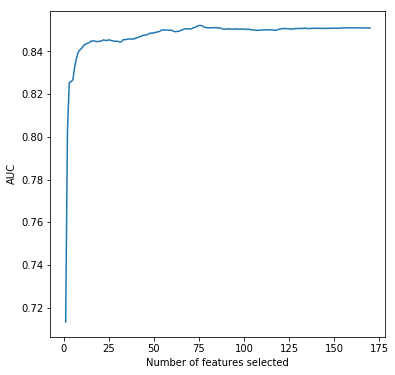

In [12]:
plt.figure(figsize=(6, 6))
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.xlabel("Number of features selected")
plt.ylabel("AUC")
plt.show()

In [13]:
features_remove = map(itemgetter(0), filter(lambda (f, r): r > 1, zip(features, selector.ranking_)))
features_remove = set(features_remove)
features_remove

{u'FF_POS_amount_2016-10_log',
 u'FF_POS_amount_2016-12_log',
 u'FF_POS_amount_2017-01_log',
 u'FF_POS_amount_2017-04_log',
 u'FF_POS_amount_2017-12_log',
 u'FF_POS_amount_2018-01_log',
 u'FF_POS_amount_quarter2_log',
 u'FF_POS_amount_quarter4_log',
 u'FF_amount_POS_div_100_std',
 u'FF_amount_POS_max_log',
 u'FF_amount_POS_mean_log',
 u'FF_amount_balanced_mean_window_week',
 u'FF_amount_dayoff_log',
 u'FF_amount_dayoff_mean_log',
 u'FF_amount_holiday_after_7_log',
 u'FF_amount_holiday_before_7_log',
 u'FF_amount_holiday_log',
 u'FF_amount_holiday_mean_log',
 u'FF_amount_in_EUR_currency_log',
 u'FF_amount_in_log_per_day',
 u'FF_amount_in_mean_window_week_log',
 u'FF_amount_log_POS_std',
 u'FF_amount_log_withdraw_per_day',
 u'FF_amount_out_max_log',
 u'FF_amount_out_mean_window_week_log',
 u'FF_amount_short_log',
 u'FF_amount_short_mean_log',
 u'FF_amount_trx_BACK_TRX_frac',
 u'FF_amount_trx_BACK_TRX_log',
 u'FF_amount_trx_C2C_IN_frac',
 u'FF_amount_trx_C2C_OUT_frac',
 u'FF_amount_trx_C2

In [14]:
features_ = filter(lambda f: f not in features_remove, features)
features_ = ['cl_id'] + features_

scores = []
feature_importances = []

kf = KFold(n_splits=5, shuffle=True, random_state=8888)

for train_index, valid_index in kf.split(df_clients_train):
    cl = LogisticRegression(max_iter=1000, random_state=8888)
    
    X_train = df_clients_train.iloc[train_index].loc[:, features_].values
    Y_train = df_clients_train.iloc[train_index].loc[:, target].values
    
    X_valid = df_clients_train.iloc[valid_index].loc[:, features_].values
    Y_valid = df_clients_train.iloc[valid_index].loc[:, target].values
    
    cl.fit(X_train, Y_train)
    Y_pred = cl.predict_proba(X_valid)[:,1]
    
    # feature_importances.append(cl.feature_importances_)
    scores.append(roc_auc_score(Y_valid, Y_pred))
    print scores[-1]
    
print "=" * 30
print "MEAN:", np.mean(scores)

0.8525560342740959
0.842169433499128
0.8677128945820535
0.8652306358590298
0.8520848310567937
MEAN: 0.8559507658542203


In [15]:
params_cl['logreg'] = (
    LogisticRegression,
    dict(max_iter=1000, random_state=8888),
    features_remove
)

### Random forest

In [16]:
from sklearn.ensemble import RandomForestClassifier

In [17]:
mask = df_clients[target].notnull()
df_clients_train = df_clients.loc[mask]
df_clients_train.head()

,FF_POS_amount_2016-10_log,FF_POS_amount_2016-11_log,FF_POS_amount_2016-12_log,FF_POS_amount_2017-01_log,FF_POS_amount_2017-02_log,FF_POS_amount_2017-03_log,FF_POS_amount_2017-04_log,FF_POS_amount_2017-05_log,FF_POS_amount_2017-06_log,FF_POS_amount_2017-07_log,FF_POS_amount_2017-08_log,FF_POS_amount_2017-09_log,FF_POS_amount_2017-10_log,FF_POS_amount_2017-11_log,FF_POS_amount_2017-12_log,FF_POS_amount_2018-01_log,FF_POS_amount_2018-02_log,FF_POS_amount_2018-03_log,FF_POS_amount_2018-04_log,FF_POS_amount_quarter1_log,FF_POS_amount_quarter2_log,FF_POS_amount_quarter3_log,FF_POS_amount_quarter4_log,FF_amount_POS,FF_amount_POS_div_100_log,FF_amount_POS_div_100_mean_log,FF_amount_POS_div_100_std,FF_amount_POS_last_month_log,FF_amount_POS_log,FF_amount_POS_max_log,FF_amount_POS_mean_log,FF_amount_balanced,FF_amount_balanced_mean_window_week,FF_amount_dayoff_log,FF_amount_dayoff_mean_log,FF_amount_holiday_after_7_log,FF_amount_holiday_before_7_log,FF_amount_holiday_log,FF_amount_holiday_mean_log,FF_amount_in_EUR_currency_log,...,FF_mcc_cat_5722_amount_log,FF_mcc_cat_5812_amount_log,FF_mcc_cat_5814_amount_log,FF_mcc_cat_5912_amount_log,FF_mcc_cat_5921_amount_log,FF_mcc_cat_5999_amount_log,FF_mcc_cat_6011_amount_log,FF_mcc_cat_6012_amount_log,FF_mcc_cat_8999_amount_log,FF_mcc_top0_amount_log,FF_mcc_top0_amount_mean_log,FF_mcc_top1_amount_log,FF_mcc_top1_amount_mean_log,FF_mcc_top2_amount_log,FF_mcc_top2_amount_mean_log,FF_num_trans_in_per_day,FF_num_trans_out_per_day,FF_num_trans_per_day,FF_trxday_mean,FF_trxday_std,FF_used_period_days,cl_id,FF_amount_POS_per_month,FF_amount_POS_per_month_log,FF_cu_ratio_days_month,FF_cu_ratio_days_week,FF_cu_ratio_days_days,FF_amount_log_out_in_ratio_per_day,FF_amount_in_log_per_day,FF_amount_out_log_per_day,FF_amount_withdraw_log_per_day,FF_amount_balanced_per_day,channel_type,target_flag,target_sum,FF_channel_type_1,FF_channel_type_2,FF_channel_type_3,FF_channel_type_4,FF_channel_type_5
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.861492,0.0,6.64379,0.0,0.0,0.0,0.0,0.000000,0.000000,8.964696,0.0,7821.000000,4.356709,3.283414,22.052967,6.643790,8.964696,8.521982,7.866339,-24383.000000,-2260.104167,0.000000,0.000000,8.964696,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,6.643790,0.000000,9.903538,10.506792,0.000000,8.521982,8.521982,7.616776,7.616776,6.643790,6.643790,0.018182,0.072727,0.090909,386.800000,21.276748,55,0,3910.500000,4.482348,27.50,27.500000,27.500000,-0.097364,0.180064,-0.194557,0.000000,-443.327273,0,0.0,0.00,0,0,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,8.276715,8.244991,11.878687,10.318540,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,8.953997,12.069389,0.0,182185.976007,7.481556,2.921243,60.540964,11.931104,12.112789,11.002117,7.498217,-137185.976007,-1352.140614,0.000000,0.000000,11.851599,10.857969,8.555837,7.457609,11.010297,...,0.000000,10.485589,11.319852,7.800573,0.000000,6.516193,11.884496,0.000000,0.000000,11.319852,7.606765,10.485589,7.541653,9.889628,7.405278,0.021505,1.096774,1.118280,344.298077,23.389849,93,1,45546.494002,3.028197,23.25,7.153846,1.823529,-0.110848,0.123243,-0.132853,0.116342,-1475.118022,0,0.0,0.00,0,0,0,0,0
5,0.0,0.0,0.0,0.0,0.0,10.853394,11.676312,10.416270,11.417794,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,12.040357,11.730638,0.000000,0.0,293778.468834,7.965893,3.293833,58.777212,11.442013,12.590585,10.936050,7.881429,-261666.848834,-2153.340938,9.466186,7.857057,12.421177,10.864421,9.466186,7.857057,8.110892,...,8.625330,8.104703,5.513429,7.498316,0.000000,6.268654,12.245298,10.430562,0.000000,10.772384,7.339025,11.289507,8.724708,8.881517,6.803047,0.053763,1.473118,1.526882,209.950704,27.567667,93,5,73444.617208,3.147646,23.25,6.642857,1.550000,-0.115423,0.127715,-0.138852,0.121123,-2813.622030,0,1.0,326211.75,0,0,0,0,0
9,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,9.059634,7.699430,7.352441,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.

In [18]:
features_remove = set()

In [19]:
features_ = filter(lambda f: f not in features_remove, features)

scores = []
feature_importances = []

kf = KFold(n_splits=5, shuffle=True, random_state=8888)

for train_index, valid_index in kf.split(df_clients_train):
    cl = RandomForestClassifier(n_estimators=400, criterion='entropy', random_state=8888)
    
    X_train = df_clients_train.iloc[train_index].loc[:, features_].values
    Y_train = df_clients_train.iloc[train_index].loc[:, target].values
    
    X_valid = df_clients_train.iloc[valid_index].loc[:, features_].values
    Y_valid = df_clients_train.iloc[valid_index].loc[:, target].values
    
    cl.fit(X_train, Y_train)
    Y_pred = cl.predict_proba(X_valid)[:,1]
    
    feature_importances.append(cl.feature_importances_)
    scores.append(roc_auc_score(Y_valid, Y_pred))
    print scores[-1]
    
print "=" * 30
print "MEAN:", np.mean(scores)

0.8668248051507965
0.8505849912796332
0.8782534638258938
0.8781781914359907
0.859829422913535
MEAN: 0.8667341749211698


Feature ranking:
[001] cl_id                                    0.0410210735525
[002] FF_amount_POS_per_month_log              0.0356406008907
[003] FF_amount_log_POS_per_month              0.0301522479336
[004] FF_cu_month                              0.0270492064958
[005] FF_used_period_days                      0.0270198782263
[006] FF_trxday_std                            0.0225406623163
[007] FF_amount_out_log_per_day                0.018542252968
[008] FF_channel_type_2                        0.0142885132972
[009] FF_amount_log_out_in_ratio_per_day       0.0135579135182
[010] FF_amount_in_log_per_day                 0.0126725788136
[011] FF_cu_week                               0.0126240250374
[012] FF_channel_type_1                        0.0123332122995
[013] FF_amount_balanced                       0.0123264240424
[014] FF_cu_ratio_days_month                   0.0116484598852
[015] FF_amount_balanced_per_day               0.00998068639701
[016] FF_cnt_trx_balanced             

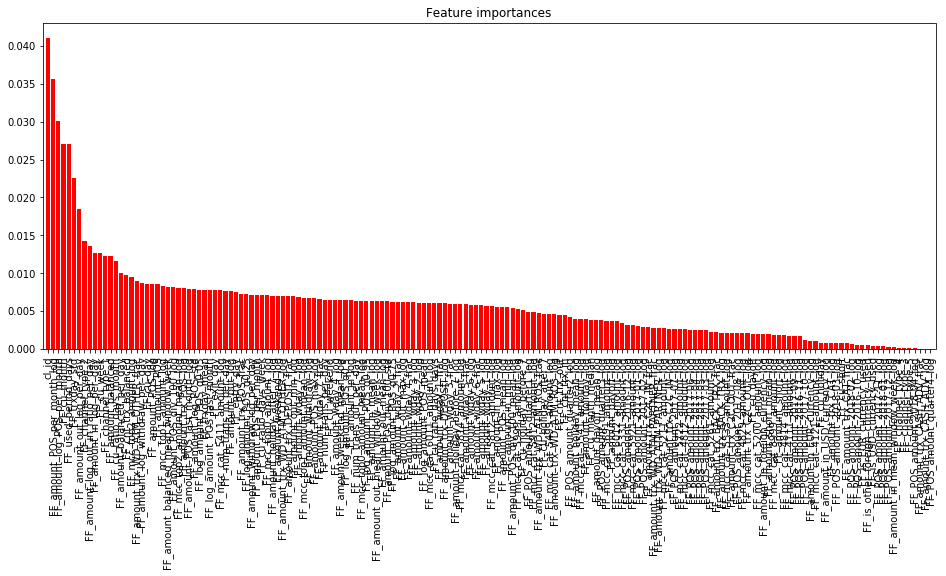

In [20]:
features_ = np.array(features_)

importances = np.mean(feature_importances, axis=0)
importances = importances / importances.sum()
indices = np.argsort(importances)[::-1]

print "Feature ranking:"

n_features = len(features_)

for f in range(n_features):
    print "[{:03}] {:40} {}".format(f + 1, features_[indices[f]], importances[indices[f]])
    
plt.figure(figsize=(16, 6))
plt.title("Feature importances")
plt.bar(range(n_features), importances[indices], color="r", align="center")
plt.xticks(range(n_features), features_[indices], rotation='vertical')
plt.xlim([-1, n_features])
plt.show()

In [21]:
features_remove = set(f for f, f_im in zip(features_, importances) if f_im < 5e-4)
features_remove

{u'FF_POS_amount_2017-11_log',
 u'FF_POS_amount_2017-12_log',
 u'FF_POS_amount_2018-01_log',
 u'FF_POS_amount_2018-04_log',
 u'FF_POS_amount_quarter4_log',
 u'FF_amount_in_mean_window_week_log',
 u'FF_amount_trx_CASH_ADV_frac',
 u'FF_amount_trx_CASH_ADV_log',
 u'FF_channel_type_3',
 u'FF_channel_type_4',
 u'FF_channel_type_5',
 u'FF_is_EUR_currency_used',
 u'FF_is_USD_currency_used',
 u'FF_is_other_foreign_currency_used'}

In [22]:
params_cl['random_forest'] = (
    RandomForestClassifier,
    dict(n_estimators=400, criterion='entropy', random_state=8888),
    features_remove,
)

### XGBoost

In [23]:
from xgboost import XGBClassifier

In [24]:
mask = df_clients[target].notnull()
df_clients_train = df_clients.loc[mask]
df_clients_train.head()

,FF_POS_amount_2016-10_log,FF_POS_amount_2016-11_log,FF_POS_amount_2016-12_log,FF_POS_amount_2017-01_log,FF_POS_amount_2017-02_log,FF_POS_amount_2017-03_log,FF_POS_amount_2017-04_log,FF_POS_amount_2017-05_log,FF_POS_amount_2017-06_log,FF_POS_amount_2017-07_log,FF_POS_amount_2017-08_log,FF_POS_amount_2017-09_log,FF_POS_amount_2017-10_log,FF_POS_amount_2017-11_log,FF_POS_amount_2017-12_log,FF_POS_amount_2018-01_log,FF_POS_amount_2018-02_log,FF_POS_amount_2018-03_log,FF_POS_amount_2018-04_log,FF_POS_amount_quarter1_log,FF_POS_amount_quarter2_log,FF_POS_amount_quarter3_log,FF_POS_amount_quarter4_log,FF_amount_POS,FF_amount_POS_div_100_log,FF_amount_POS_div_100_mean_log,FF_amount_POS_div_100_std,FF_amount_POS_last_month_log,FF_amount_POS_log,FF_amount_POS_max_log,FF_amount_POS_mean_log,FF_amount_balanced,FF_amount_balanced_mean_window_week,FF_amount_dayoff_log,FF_amount_dayoff_mean_log,FF_amount_holiday_after_7_log,FF_amount_holiday_before_7_log,FF_amount_holiday_log,FF_amount_holiday_mean_log,FF_amount_in_EUR_currency_log,...,FF_mcc_cat_5722_amount_log,FF_mcc_cat_5812_amount_log,FF_mcc_cat_5814_amount_log,FF_mcc_cat_5912_amount_log,FF_mcc_cat_5921_amount_log,FF_mcc_cat_5999_amount_log,FF_mcc_cat_6011_amount_log,FF_mcc_cat_6012_amount_log,FF_mcc_cat_8999_amount_log,FF_mcc_top0_amount_log,FF_mcc_top0_amount_mean_log,FF_mcc_top1_amount_log,FF_mcc_top1_amount_mean_log,FF_mcc_top2_amount_log,FF_mcc_top2_amount_mean_log,FF_num_trans_in_per_day,FF_num_trans_out_per_day,FF_num_trans_per_day,FF_trxday_mean,FF_trxday_std,FF_used_period_days,cl_id,FF_amount_POS_per_month,FF_amount_POS_per_month_log,FF_cu_ratio_days_month,FF_cu_ratio_days_week,FF_cu_ratio_days_days,FF_amount_log_out_in_ratio_per_day,FF_amount_in_log_per_day,FF_amount_out_log_per_day,FF_amount_withdraw_log_per_day,FF_amount_balanced_per_day,channel_type,target_flag,target_sum,FF_channel_type_1,FF_channel_type_2,FF_channel_type_3,FF_channel_type_4,FF_channel_type_5
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.861492,0.0,6.64379,0.0,0.0,0.0,0.0,0.000000,0.000000,8.964696,0.0,7821.000000,4.356709,3.283414,22.052967,6.643790,8.964696,8.521982,7.866339,-24383.000000,-2260.104167,0.000000,0.000000,8.964696,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,6.643790,0.000000,9.903538,10.506792,0.000000,8.521982,8.521982,7.616776,7.616776,6.643790,6.643790,0.018182,0.072727,0.090909,386.800000,21.276748,55,0,3910.500000,4.482348,27.50,27.500000,27.500000,-0.097364,0.180064,-0.194557,0.000000,-443.327273,0,0.0,0.00,0,0,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,8.276715,8.244991,11.878687,10.318540,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,8.953997,12.069389,0.0,182185.976007,7.481556,2.921243,60.540964,11.931104,12.112789,11.002117,7.498217,-137185.976007,-1352.140614,0.000000,0.000000,11.851599,10.857969,8.555837,7.457609,11.010297,...,0.000000,10.485589,11.319852,7.800573,0.000000,6.516193,11.884496,0.000000,0.000000,11.319852,7.606765,10.485589,7.541653,9.889628,7.405278,0.021505,1.096774,1.118280,344.298077,23.389849,93,1,45546.494002,3.028197,23.25,7.153846,1.823529,-0.110848,0.123243,-0.132853,0.116342,-1475.118022,0,0.0,0.00,0,0,0,0,0
5,0.0,0.0,0.0,0.0,0.0,10.853394,11.676312,10.416270,11.417794,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,12.040357,11.730638,0.000000,0.0,293778.468834,7.965893,3.293833,58.777212,11.442013,12.590585,10.936050,7.881429,-261666.848834,-2153.340938,9.466186,7.857057,12.421177,10.864421,9.466186,7.857057,8.110892,...,8.625330,8.104703,5.513429,7.498316,0.000000,6.268654,12.245298,10.430562,0.000000,10.772384,7.339025,11.289507,8.724708,8.881517,6.803047,0.053763,1.473118,1.526882,209.950704,27.567667,93,5,73444.617208,3.147646,23.25,6.642857,1.550000,-0.115423,0.127715,-0.138852,0.121123,-2813.622030,0,1.0,326211.75,0,0,0,0,0
9,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,9.059634,7.699430,7.352441,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.

In [25]:
features_remove = set()

In [26]:
features_ = filter(lambda f: f not in features_remove, features)

scores = []
feature_importances = []

kf = KFold(n_splits=5, shuffle=True, random_state=8888)

for train_index, valid_index in kf.split(df_clients_train):
    cl = XGBClassifier(n_estimators=300, max_depth=5, random_state=8888)
    
    X_train = df_clients_train.iloc[train_index].loc[:, features_].values
    Y_train = df_clients_train.iloc[train_index].loc[:, target].values
    
    X_valid = df_clients_train.iloc[valid_index].loc[:, features_].values
    Y_valid = df_clients_train.iloc[valid_index].loc[:, target].values
    
    cl.fit(X_train, Y_train)
    Y_pred = cl.predict_proba(X_valid)[:,1]
    
    feature_importances.append(cl.feature_importances_)
    scores.append(roc_auc_score(Y_valid, Y_pred))
    print scores[-1]
    
print "=" * 30
print "MEAN:", np.mean(scores)

0.8646826741540399
0.8494121826755376
0.8684195477419776
0.8720495747695247
0.8577870727403438
MEAN: 0.8624702104162847


Feature ranking:
[001] cl_id                                    0.038187276572
[002] FF_trxday_std                            0.0221911631525
[003] FF_amount_log_POS_per_month              0.0185272432864
[004] FF_amount_out_log_per_day                0.0137084098533
[005] FF_amount_wday_3_frac                    0.0129112619907
[006] FF_amount_POS_last_month_log             0.0128896217793
[007] FF_amount_out_min_log                    0.0127176316455
[008] FF_amount_wday_4_frac                    0.0126708354801
[009] FF_entry_day                             0.0123697509989
[010] FF_amount_log_POS_std                    0.012253254652
[011] FF_mcc_top0_amount_log                   0.0120989885181
[012] FF_amount_wday_2_frac                    0.0115325218067
[013] FF_mcc_top1_amount_mean_log              0.0114606488496
[014] FF_mcc_top2_amount_mean_log              0.0113483574241
[015] FF_exit_day                              0.0113118272275
[016] FF_amount_in_min_log              

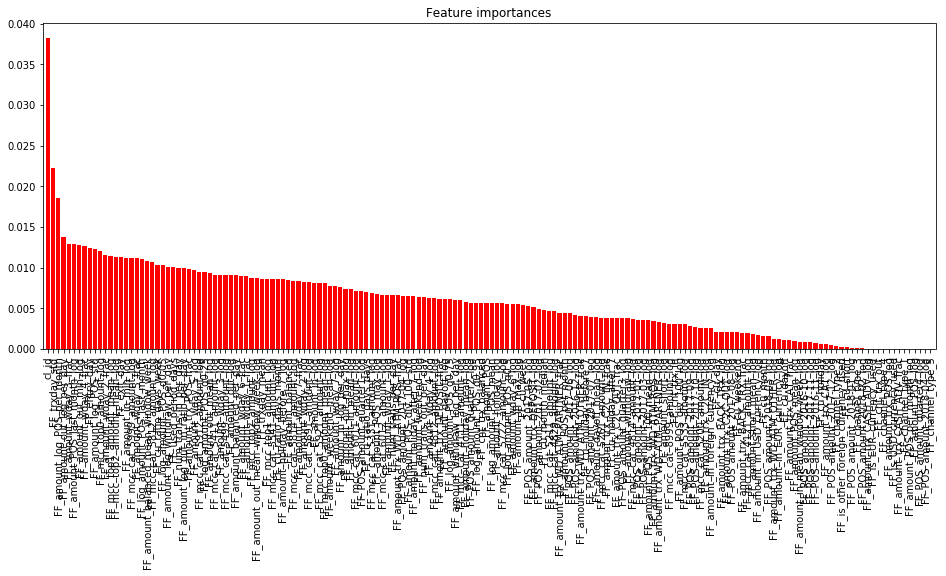

In [27]:
features_ = np.array(features_)

importances = np.mean(feature_importances, axis=0)
importances = importances / importances.sum()
indices = np.argsort(importances)[::-1]

print "Feature ranking:"

n_features = len(features_)

for f in range(n_features):
    print "[{:03}] {:40} {}".format(f + 1, features_[indices[f]], importances[indices[f]])
    
plt.figure(figsize=(16, 6))
plt.title("Feature importances")
plt.bar(range(n_features), importances[indices], color="r", align="center")
plt.xticks(range(n_features), features_[indices], rotation='vertical')
plt.xlim([-1, n_features])
plt.show()

In [28]:
features_remove = set(f for f, f_im in zip(features_, importances) if f_im < 5e-4)
features_remove

{u'FF_POS_amount_2018-01_log',
 u'FF_POS_amount_2018-02_log',
 u'FF_POS_amount_2018-04_log',
 u'FF_POS_amount_quarter4_log',
 u'FF_amount_POS_log',
 u'FF_amount_POS_per_month_log',
 u'FF_amount_trx_CASH_ADV_frac',
 u'FF_amount_trx_CASH_ADV_log',
 u'FF_amount_trx_POS_log',
 u'FF_channel_type_1',
 u'FF_channel_type_2',
 u'FF_channel_type_3',
 u'FF_channel_type_4',
 u'FF_channel_type_5',
 u'FF_cnt_trx_out',
 u'FF_cu_short',
 u'FF_is_EUR_currency_used',
 u'FF_is_USD_currency_used',
 u'FF_is_other_foreign_currency_used'}

In [29]:
features_ = filter(lambda f: f not in features_remove, features)

In [30]:
import xgboost as xgb

In [31]:
%%time

params = {
    'max_depth': 5,
    'learning_rate': 0.001,
    'silent': 0,
    'objective': 'binary:logistic',
    'seed': 8888,
}

X_train = xgb.DMatrix(df_clients_train.loc[:, features_], label=df_clients_train.loc[:, target])

trees = 12000
cv = xgb.cv(params, X_train, metrics=('auc'), show_stdv=True,
            num_boost_round=trees, nfold=5, early_stopping_rounds=150)

CPU times: user 28min 26s, sys: 0 ns, total: 28min 26s
Wall time: 28min 38s


test-auc-mean     0.867883
test-auc-std      0.009064
train-auc-mean    0.980557
train-auc-std     0.001223
Name: 6991, dtype: float64


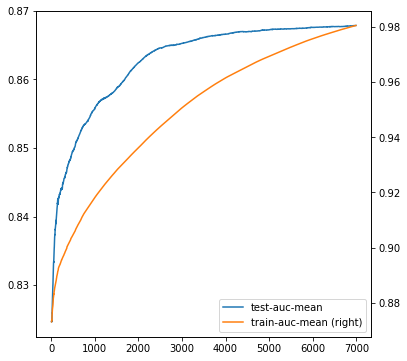

In [32]:
cv[10:].plot(figsize=(6, 6), y=['test-auc-mean', 'train-auc-mean'], secondary_y='train-auc-mean')
print (cv.loc[cv['test-auc-mean'].values.argmax()])
trees = cv['test-auc-mean'].values.argmax()

In [33]:
params['n_estimators'] = trees

In [34]:
params_cl['xgb'] = (XGBClassifier, params, features_remove)

### LightGBM

In [35]:
from lightgbm import LGBMClassifier

In [36]:
mask = df_clients[target].notnull()
df_clients_train = df_clients.loc[mask]
df_clients_train.head()

,FF_POS_amount_2016-10_log,FF_POS_amount_2016-11_log,FF_POS_amount_2016-12_log,FF_POS_amount_2017-01_log,FF_POS_amount_2017-02_log,FF_POS_amount_2017-03_log,FF_POS_amount_2017-04_log,FF_POS_amount_2017-05_log,FF_POS_amount_2017-06_log,FF_POS_amount_2017-07_log,FF_POS_amount_2017-08_log,FF_POS_amount_2017-09_log,FF_POS_amount_2017-10_log,FF_POS_amount_2017-11_log,FF_POS_amount_2017-12_log,FF_POS_amount_2018-01_log,FF_POS_amount_2018-02_log,FF_POS_amount_2018-03_log,FF_POS_amount_2018-04_log,FF_POS_amount_quarter1_log,FF_POS_amount_quarter2_log,FF_POS_amount_quarter3_log,FF_POS_amount_quarter4_log,FF_amount_POS,FF_amount_POS_div_100_log,FF_amount_POS_div_100_mean_log,FF_amount_POS_div_100_std,FF_amount_POS_last_month_log,FF_amount_POS_log,FF_amount_POS_max_log,FF_amount_POS_mean_log,FF_amount_balanced,FF_amount_balanced_mean_window_week,FF_amount_dayoff_log,FF_amount_dayoff_mean_log,FF_amount_holiday_after_7_log,FF_amount_holiday_before_7_log,FF_amount_holiday_log,FF_amount_holiday_mean_log,FF_amount_in_EUR_currency_log,...,FF_mcc_cat_5722_amount_log,FF_mcc_cat_5812_amount_log,FF_mcc_cat_5814_amount_log,FF_mcc_cat_5912_amount_log,FF_mcc_cat_5921_amount_log,FF_mcc_cat_5999_amount_log,FF_mcc_cat_6011_amount_log,FF_mcc_cat_6012_amount_log,FF_mcc_cat_8999_amount_log,FF_mcc_top0_amount_log,FF_mcc_top0_amount_mean_log,FF_mcc_top1_amount_log,FF_mcc_top1_amount_mean_log,FF_mcc_top2_amount_log,FF_mcc_top2_amount_mean_log,FF_num_trans_in_per_day,FF_num_trans_out_per_day,FF_num_trans_per_day,FF_trxday_mean,FF_trxday_std,FF_used_period_days,cl_id,FF_amount_POS_per_month,FF_amount_POS_per_month_log,FF_cu_ratio_days_month,FF_cu_ratio_days_week,FF_cu_ratio_days_days,FF_amount_log_out_in_ratio_per_day,FF_amount_in_log_per_day,FF_amount_out_log_per_day,FF_amount_withdraw_log_per_day,FF_amount_balanced_per_day,channel_type,target_flag,target_sum,FF_channel_type_1,FF_channel_type_2,FF_channel_type_3,FF_channel_type_4,FF_channel_type_5
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.861492,0.0,6.64379,0.0,0.0,0.0,0.0,0.000000,0.000000,8.964696,0.0,7821.000000,4.356709,3.283414,22.052967,6.643790,8.964696,8.521982,7.866339,-24383.000000,-2260.104167,0.000000,0.000000,8.964696,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,6.643790,0.000000,9.903538,10.506792,0.000000,8.521982,8.521982,7.616776,7.616776,6.643790,6.643790,0.018182,0.072727,0.090909,386.800000,21.276748,55,0,3910.500000,4.482348,27.50,27.500000,27.500000,-0.097364,0.180064,-0.194557,0.000000,-443.327273,0,0.0,0.00,0,0,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,8.276715,8.244991,11.878687,10.318540,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,8.953997,12.069389,0.0,182185.976007,7.481556,2.921243,60.540964,11.931104,12.112789,11.002117,7.498217,-137185.976007,-1352.140614,0.000000,0.000000,11.851599,10.857969,8.555837,7.457609,11.010297,...,0.000000,10.485589,11.319852,7.800573,0.000000,6.516193,11.884496,0.000000,0.000000,11.319852,7.606765,10.485589,7.541653,9.889628,7.405278,0.021505,1.096774,1.118280,344.298077,23.389849,93,1,45546.494002,3.028197,23.25,7.153846,1.823529,-0.110848,0.123243,-0.132853,0.116342,-1475.118022,0,0.0,0.00,0,0,0,0,0
5,0.0,0.0,0.0,0.0,0.0,10.853394,11.676312,10.416270,11.417794,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,12.040357,11.730638,0.000000,0.0,293778.468834,7.965893,3.293833,58.777212,11.442013,12.590585,10.936050,7.881429,-261666.848834,-2153.340938,9.466186,7.857057,12.421177,10.864421,9.466186,7.857057,8.110892,...,8.625330,8.104703,5.513429,7.498316,0.000000,6.268654,12.245298,10.430562,0.000000,10.772384,7.339025,11.289507,8.724708,8.881517,6.803047,0.053763,1.473118,1.526882,209.950704,27.567667,93,5,73444.617208,3.147646,23.25,6.642857,1.550000,-0.115423,0.127715,-0.138852,0.121123,-2813.622030,0,1.0,326211.75,0,0,0,0,0
9,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,9.059634,7.699430,7.352441,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.

In [37]:
features_remove = set()

In [38]:
features_ = filter(lambda f: f not in features_remove, features)

scores = []
feature_importances = []

kf = KFold(n_splits=5, shuffle=True, random_state=8888)

for train_index, valid_index in kf.split(df_clients_train):
    cl = LGBMClassifier(n_estimators=400, max_depth=7, learning_rate=0.01, random_state=8888)
    
    X_train = df_clients_train.iloc[train_index].loc[:, features_].values
    Y_train = df_clients_train.iloc[train_index].loc[:, target].values
    
    X_valid = df_clients_train.iloc[valid_index].loc[:, features_].values
    Y_valid = df_clients_train.iloc[valid_index].loc[:, target].values
    
    cl.fit(X_train, Y_train)
    Y_pred = cl.predict_proba(X_valid)[:,1]
    
    feature_importances.append(cl.feature_importances_)
    scores.append(roc_auc_score(Y_valid, Y_pred))
    print scores[-1]
    
print "=" * 30
print "MEAN:", np.mean(scores)

0.8658162688999693
0.8503730379174472
0.8741381282269133
0.8804217387290846
0.8604176197634141
MEAN: 0.8662333587073657


Feature ranking:
[001] cl_id                                    0.0654528462476
[002] FF_trxday_std                            0.0385340698586
[003] FF_amount_log_POS_per_month              0.0244822349427
[004] FF_used_period_days                      0.0201598771716
[005] FF_num_trans_in_per_day                  0.0186912768478
[006] FF_mcc_cat_5999_amount_log               0.017956976686
[007] FF_amount_log_withdraw_per_day           0.0151365965187
[008] FF_amount_out_log_per_day                0.0146526259575
[009] FF_log_amount_POS_q0.05                  0.0127334323526
[010] FF_cu_week                               0.0126333005123
[011] FF_exit_day                              0.0126166118723
[012] FF_amount_log_POS_std                    0.0121660185911
[013] FF_amount_POS_last_month_log             0.0121326413111
[014] FF_amount_log_out_in_ratio_per_day       0.0114317184293
[015] FF_mcc_top2_amount_mean_log              0.0113649638691
[016] FF_amount_balanced_per_day       

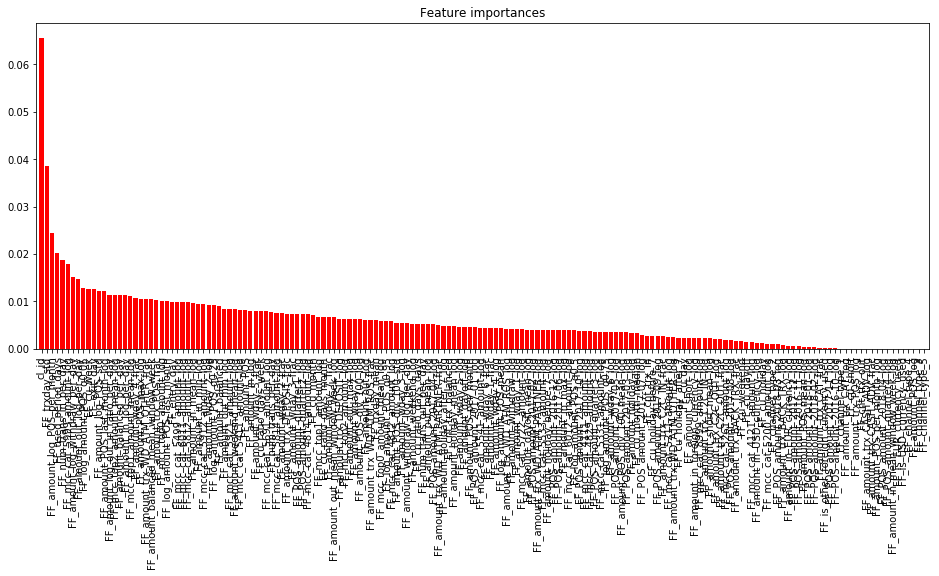

In [39]:
features_ = np.array(features_)

importances = np.mean(feature_importances, axis=0)
importances = importances / importances.sum()
indices = np.argsort(importances)[::-1]

print "Feature ranking:"

n_features = len(features_)

for f in range(n_features):
    print "[{:03}] {:40} {}".format(f + 1, features_[indices[f]], importances[indices[f]])
    
plt.figure(figsize=(16, 6))
plt.title("Feature importances")
plt.bar(range(n_features), importances[indices], color="r", align="center")
plt.xticks(range(n_features), features_[indices], rotation='vertical')
plt.xlim([-1, n_features])
plt.show()

In [40]:
features_remove = set(f for f, f_im in zip(features_, importances) if f_im < 5e-4)
features_remove

{u'FF_POS_amount_2016-10_log',
 u'FF_POS_amount_2017-11_log',
 u'FF_POS_amount_2018-01_log',
 u'FF_POS_amount_2018-02_log',
 u'FF_POS_amount_2018-04_log',
 u'FF_POS_amount_quarter4_log',
 u'FF_amount_POS_log',
 u'FF_amount_POS_mean_log',
 u'FF_amount_POS_per_month_log',
 u'FF_amount_in_mean_window_week_log',
 u'FF_amount_trx_CASH_ADV_frac',
 u'FF_amount_trx_CASH_ADV_log',
 u'FF_amount_trx_CAT_frac',
 u'FF_amount_trx_CAT_log',
 u'FF_amount_trx_POS_log',
 u'FF_channel_type_1',
 u'FF_channel_type_3',
 u'FF_channel_type_4',
 u'FF_channel_type_5',
 u'FF_cnt_trx_out',
 u'FF_cu_short',
 u'FF_is_EUR_currency_used',
 u'FF_is_USD_currency_used',
 u'FF_is_other_foreign_currency_used'}

In [41]:
features_ = filter(lambda f: f not in features_remove, features)

In [42]:
import lightgbm as lgbm

In [44]:
%%time

params = {
    'max_depth': 5,
    'learning_rate': 0.001,
    'silent': 0,
    'objective': 'binary',
    'seed': 8888,
}

X_train = lgbm.Dataset(df_clients_train.loc[:, features_], label=df_clients_train.loc[:, target])

trees = 12000
cv = lgbm.cv(params, X_train, metrics=('auc'), show_stdv=True, stratified=False,
            num_boost_round=trees, nfold=5, early_stopping_rounds=150)

CPU times: user 5min 4s, sys: 0 ns, total: 5min 4s
Wall time: 5min 17s


In [47]:
cv = pd.DataFrame(cv)

auc-mean    0.867347
auc-stdv    0.008927
Name: 3999, dtype: float64


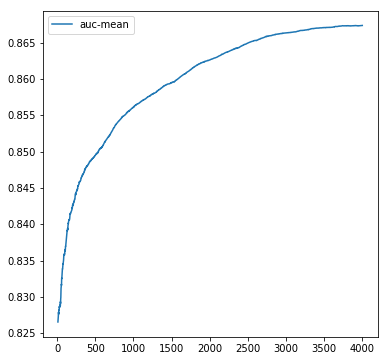

In [48]:
cv[10:].plot(figsize=(6, 6), y=['auc-mean'])
print (cv.loc[cv['auc-mean'].values.argmax()])
trees = cv['auc-mean'].values.argmax()

In [49]:
params['n_estimators'] = trees

In [50]:
params_cl['lgbm'] = (LGBMClassifier, params, features_remove)

### CatBoost

In [51]:
from catboost import CatBoostClassifier

class CatBoostClassifierSklearnWrapper(CatBoostClassifier):
    # Обертка нужна, чтобы работал RFECV
    
    def __getattr__(self, attr):
        if attr == 'coef_':
            return np.array(self.feature_importances_)
        else:
            return object.__getattribute__(self, attr)

In [52]:
mask = df_clients[target].notnull()
df_clients_train = df_clients.loc[mask]
df_clients_train.head()

,FF_POS_amount_2016-10_log,FF_POS_amount_2016-11_log,FF_POS_amount_2016-12_log,FF_POS_amount_2017-01_log,FF_POS_amount_2017-02_log,FF_POS_amount_2017-03_log,FF_POS_amount_2017-04_log,FF_POS_amount_2017-05_log,FF_POS_amount_2017-06_log,FF_POS_amount_2017-07_log,FF_POS_amount_2017-08_log,FF_POS_amount_2017-09_log,FF_POS_amount_2017-10_log,FF_POS_amount_2017-11_log,FF_POS_amount_2017-12_log,FF_POS_amount_2018-01_log,FF_POS_amount_2018-02_log,FF_POS_amount_2018-03_log,FF_POS_amount_2018-04_log,FF_POS_amount_quarter1_log,FF_POS_amount_quarter2_log,FF_POS_amount_quarter3_log,FF_POS_amount_quarter4_log,FF_amount_POS,FF_amount_POS_div_100_log,FF_amount_POS_div_100_mean_log,FF_amount_POS_div_100_std,FF_amount_POS_last_month_log,FF_amount_POS_log,FF_amount_POS_max_log,FF_amount_POS_mean_log,FF_amount_balanced,FF_amount_balanced_mean_window_week,FF_amount_dayoff_log,FF_amount_dayoff_mean_log,FF_amount_holiday_after_7_log,FF_amount_holiday_before_7_log,FF_amount_holiday_log,FF_amount_holiday_mean_log,FF_amount_in_EUR_currency_log,...,FF_mcc_cat_5722_amount_log,FF_mcc_cat_5812_amount_log,FF_mcc_cat_5814_amount_log,FF_mcc_cat_5912_amount_log,FF_mcc_cat_5921_amount_log,FF_mcc_cat_5999_amount_log,FF_mcc_cat_6011_amount_log,FF_mcc_cat_6012_amount_log,FF_mcc_cat_8999_amount_log,FF_mcc_top0_amount_log,FF_mcc_top0_amount_mean_log,FF_mcc_top1_amount_log,FF_mcc_top1_amount_mean_log,FF_mcc_top2_amount_log,FF_mcc_top2_amount_mean_log,FF_num_trans_in_per_day,FF_num_trans_out_per_day,FF_num_trans_per_day,FF_trxday_mean,FF_trxday_std,FF_used_period_days,cl_id,FF_amount_POS_per_month,FF_amount_POS_per_month_log,FF_cu_ratio_days_month,FF_cu_ratio_days_week,FF_cu_ratio_days_days,FF_amount_log_out_in_ratio_per_day,FF_amount_in_log_per_day,FF_amount_out_log_per_day,FF_amount_withdraw_log_per_day,FF_amount_balanced_per_day,channel_type,target_flag,target_sum,FF_channel_type_1,FF_channel_type_2,FF_channel_type_3,FF_channel_type_4,FF_channel_type_5
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.861492,0.0,6.64379,0.0,0.0,0.0,0.0,0.000000,0.000000,8.964696,0.0,7821.000000,4.356709,3.283414,22.052967,6.643790,8.964696,8.521982,7.866339,-24383.000000,-2260.104167,0.000000,0.000000,8.964696,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,6.643790,0.000000,9.903538,10.506792,0.000000,8.521982,8.521982,7.616776,7.616776,6.643790,6.643790,0.018182,0.072727,0.090909,386.800000,21.276748,55,0,3910.500000,4.482348,27.50,27.500000,27.500000,-0.097364,0.180064,-0.194557,0.000000,-443.327273,0,0.0,0.00,0,0,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,8.276715,8.244991,11.878687,10.318540,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,8.953997,12.069389,0.0,182185.976007,7.481556,2.921243,60.540964,11.931104,12.112789,11.002117,7.498217,-137185.976007,-1352.140614,0.000000,0.000000,11.851599,10.857969,8.555837,7.457609,11.010297,...,0.000000,10.485589,11.319852,7.800573,0.000000,6.516193,11.884496,0.000000,0.000000,11.319852,7.606765,10.485589,7.541653,9.889628,7.405278,0.021505,1.096774,1.118280,344.298077,23.389849,93,1,45546.494002,3.028197,23.25,7.153846,1.823529,-0.110848,0.123243,-0.132853,0.116342,-1475.118022,0,0.0,0.00,0,0,0,0,0
5,0.0,0.0,0.0,0.0,0.0,10.853394,11.676312,10.416270,11.417794,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,12.040357,11.730638,0.000000,0.0,293778.468834,7.965893,3.293833,58.777212,11.442013,12.590585,10.936050,7.881429,-261666.848834,-2153.340938,9.466186,7.857057,12.421177,10.864421,9.466186,7.857057,8.110892,...,8.625330,8.104703,5.513429,7.498316,0.000000,6.268654,12.245298,10.430562,0.000000,10.772384,7.339025,11.289507,8.724708,8.881517,6.803047,0.053763,1.473118,1.526882,209.950704,27.567667,93,5,73444.617208,3.147646,23.25,6.642857,1.550000,-0.115423,0.127715,-0.138852,0.121123,-2813.622030,0,1.0,326211.75,0,0,0,0,0
9,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,9.059634,7.699430,7.352441,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.

In [53]:
features_remove = set()

In [54]:
features_ = filter(lambda f: f not in features_remove, features)

scores = []
feature_importances = []

kf = KFold(n_splits=5, shuffle=True, random_state=8888)

for train_index, valid_index in kf.split(df_clients_train):
    cl = CatBoostClassifier(n_estimators=300, random_state=8888, verbose=False)
    
    X_train = df_clients_train.iloc[train_index].loc[:, features_].values
    Y_train = df_clients_train.iloc[train_index].loc[:, target].values
    
    X_valid = df_clients_train.iloc[valid_index].loc[:, features_].values
    Y_valid = df_clients_train.iloc[valid_index].loc[:, target].values
    
    cl.fit(X_train, Y_train)
    Y_pred = cl.predict_proba(X_valid)[:,1]
    
    feature_importances.append(cl.feature_importances_)
    scores.append(roc_auc_score(Y_valid, Y_pred))
    print scores[-1]
    
print "=" * 30
print "MEAN:", np.mean(scores)

0.8690193800325958
0.8525208319875978
0.8748978824913405
0.8887537676744568
0.8625089863407621
MEAN: 0.8695401697053505


Feature ranking:
[001] cl_id                                    0.116162281723
[002] FF_cu_month                              0.0506627351449
[003] FF_used_period_days                      0.0412806525372
[004] FF_trxday_std                            0.0374787324401
[005] FF_amount_log_POS_per_month              0.033206610308
[006] FF_amount_POS_per_month_log              0.0301622357222
[007] FF_amount_balanced                       0.0174277677828
[008] FF_cu_week                               0.0160452091361
[009] FF_amount_out_log_per_day                0.0142703158681
[010] FF_mcc_cat_5999_amount_log               0.0140002345897
[011] FF_amount_in_log_per_day                 0.0136496253326
[012] FF_amount_trx_WD_ATM_OTHER_frac          0.013389142222
[013] FF_amount_log_withdraw_per_day           0.0123361055494
[014] FF_num_trans_in_per_day                  0.0116789937988
[015] FF_amount_log_out_in_ratio_per_day       0.0110704788203
[016] FF_cu_ratio_days_month             

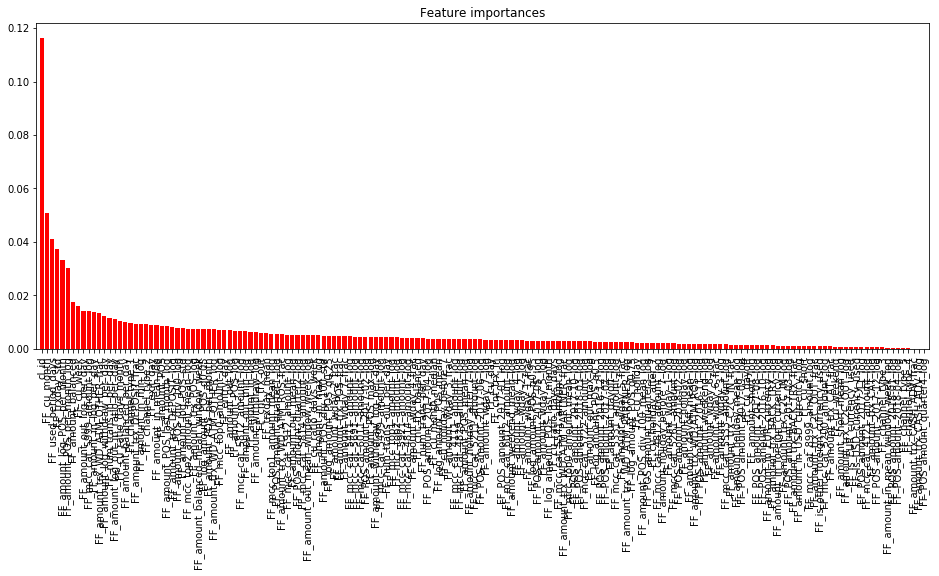

In [55]:
features_ = np.array(features_)

importances = np.mean(feature_importances, axis=0)
importances = importances / importances.sum()
indices = np.argsort(importances)[::-1]

print "Feature ranking:"

n_features = len(features_)

for f in range(n_features):
    print "[{:03}] {:40} {}".format(f + 1, features_[indices[f]], importances[indices[f]])
    
plt.figure(figsize=(16, 6))
plt.title("Feature importances")
plt.bar(range(n_features), importances[indices], color="r", align="center")
plt.xticks(range(n_features), features_[indices], rotation='vertical')
plt.xlim([-1, n_features])
plt.show()

In [56]:
features_remove = set(f for f, f_im in zip(features_, importances) if f_im < 5e-4)
features_remove

{u'FF_POS_amount_2018-01_log',
 u'FF_POS_amount_2018-04_log',
 u'FF_POS_amount_quarter4_log',
 u'FF_amount_in_mean_window_week_log',
 u'FF_amount_trx_CASH_ADV_frac',
 u'FF_amount_trx_CASH_ADV_log',
 u'FF_channel_type_4',
 u'FF_channel_type_5'}

In [57]:
features_ = filter(lambda f: f not in features_remove, features)

In [58]:
import catboost

In [61]:
%%time

params = {
    'max_depth': 5,
    'learning_rate': 0.01,
    'logging_level': 'Silent',
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'od_wait': 150,
    'random_seed': 8888,
}

X_train = catboost.Pool(df_clients_train.loc[:, features_], label=df_clients_train.loc[:, target])

trees = 7000
cv = catboost.cv(X_train, params, num_boost_round=trees, nfold=5)

CPU times: user 2h 42min 30s, sys: 18min 13s, total: 3h 44s
Wall time: 48min 32s


In [63]:
cv.columns = map(lambda s: s.lower(), cv.columns)

test-auc-mean         0.869980
test-auc-std          0.010166
test-logloss-mean     0.447140
test-logloss-std      0.014924
train-auc-mean        0.961514
train-auc-std         0.001091
train-logloss-mean    0.298428
train-logloss-std     0.005713
Name: 1553, dtype: float64


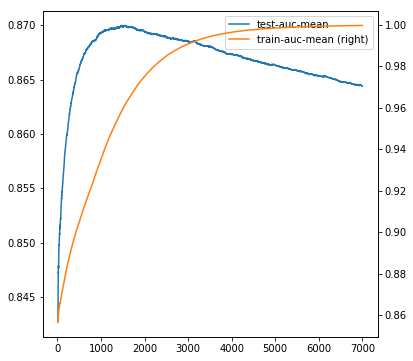

In [64]:
cv[10:].plot(figsize=(6, 6), y=['test-auc-mean', 'train-auc-mean'], secondary_y='train-auc-mean')
print (cv.loc[cv['test-auc-mean'].values.argmax()])
trees = cv['test-auc-mean'].values.argmax()

In [83]:
params['n_estimators'] = trees

In [84]:
params_cl['catboost'] = (CatBoostClassifier, params, features_remove)

### Бэггинг из классификаторов

In [85]:
target = "target_flag"

features = filter(lambda s: s not in {
        "cl_id", "target_flag", "target_sum", "trx_datetime", "channel_type"
    }, df_clients.columns)
features = ["cl_id"] + features
features

['cl_id',
 u'FF_POS_amount_2016-10_log',
 u'FF_POS_amount_2016-11_log',
 u'FF_POS_amount_2016-12_log',
 u'FF_POS_amount_2017-01_log',
 u'FF_POS_amount_2017-02_log',
 u'FF_POS_amount_2017-03_log',
 u'FF_POS_amount_2017-04_log',
 u'FF_POS_amount_2017-05_log',
 u'FF_POS_amount_2017-06_log',
 u'FF_POS_amount_2017-07_log',
 u'FF_POS_amount_2017-08_log',
 u'FF_POS_amount_2017-09_log',
 u'FF_POS_amount_2017-10_log',
 u'FF_POS_amount_2017-11_log',
 u'FF_POS_amount_2017-12_log',
 u'FF_POS_amount_2018-01_log',
 u'FF_POS_amount_2018-02_log',
 u'FF_POS_amount_2018-03_log',
 u'FF_POS_amount_2018-04_log',
 u'FF_POS_amount_quarter1_log',
 u'FF_POS_amount_quarter2_log',
 u'FF_POS_amount_quarter3_log',
 u'FF_POS_amount_quarter4_log',
 u'FF_amount_POS',
 u'FF_amount_POS_div_100_log',
 u'FF_amount_POS_div_100_mean_log',
 u'FF_amount_POS_div_100_std',
 u'FF_amount_POS_last_month_log',
 u'FF_amount_POS_log',
 u'FF_amount_POS_max_log',
 u'FF_amount_POS_mean_log',
 u'FF_amount_balanced',
 u'FF_amount_balance

In [86]:
from sklearn.model_selection import train_test_split

In [97]:
mask = df_clients[target].notnull()

Y_pred = dict()

for cl_key in params_cl.iterkeys():
    for seed in np.random.randint(100, 10000, 5):
        if cl_key == 'logreg':
            df_clients_train = df_clients_scaled.loc[mask]
            df_clients_test  = df_clients_scaled.loc[~mask]
        else:
            df_clients_train = df_clients.loc[mask]
            df_clients_test  = df_clients.loc[~mask]
        
        cl_cls, cl_params, features_remove = params_cl[cl_key]
        features_ = filter(lambda f: f not in features_remove, features)
        
        X_train, X_valid, Y_train, Y_valid = train_test_split(
            df_clients_train.loc[:, features_].values,
            df_clients_train.loc[:, target].values,
            test_size=0.2, random_state=seed)
        X_test = df_clients_test.loc[:, features_].values
            
        cl = cl_cls(**cl_params)
        if cl_key == 'catboost':
            cl.set_params(random_seed=seed)
        else:
            cl.set_params(random_state=seed)
        cl.fit(X_train, Y_train)        
        Y_pred['{}_{}'.format(cl_key, seed)] = cl.predict_proba(X_test)[:,1]
            
        score = roc_auc_score(Y_valid, cl.predict_proba(X_valid)[:,1])
        print 'cl={}; seed={:>4d}; score={:>.6f}; done!'.format(cl_key, seed, score)
    print "=" * 80

cl=lgbm; seed=1419; score=0.849718; done!
cl=lgbm; seed=7569; score=0.877127; done!
cl=lgbm; seed=8453; score=0.871220; done!
cl=lgbm; seed=2119; score=0.866654; done!
cl=lgbm; seed=7328; score=0.866046; done!
cl=xgb; seed=2054; score=0.870373; done!
cl=xgb; seed=8156; score=0.883746; done!
cl=xgb; seed=9483; score=0.875796; done!
cl=xgb; seed=2174; score=0.867759; done!
cl=xgb; seed=5721; score=0.875768; done!
cl=random_forest; seed=7699; score=0.878900; done!
cl=random_forest; seed=8874; score=0.872132; done!
cl=random_forest; seed=2049; score=0.861697; done!
cl=random_forest; seed=1637; score=0.872265; done!
cl=random_forest; seed=9184; score=0.850544; done!
cl=logreg; seed=3770; score=0.834258; done!
cl=logreg; seed= 126; score=0.851921; done!
cl=logreg; seed=8129; score=0.840355; done!
cl=logreg; seed=3817; score=0.876406; done!
cl=logreg; seed= 400; score=0.856018; done!
cl=catboost; seed= 382; score=0.877130; done!
cl=catboost; seed=6322; score=0.876792; done!
cl=catboost; seed=

AttributeError: 'module' object has no attribute 'DataFrameme'

In [98]:
Y_pred = pd.DataFrame(Y_pred, index=df_clients.loc[~mask, "cl_id"])
Y_pred.head()

,catboost_3004,catboost_3035,catboost_382,catboost_4161,catboost_6322,lgbm_1419,lgbm_2119,lgbm_7328,lgbm_7569,lgbm_8453,logreg_126,logreg_3770,logreg_3817,logreg_400,logreg_8129,random_forest_1637,random_forest_2049,random_forest_7699,random_forest_8874,random_forest_9184,xgb_2054,xgb_2174,xgb_5721,xgb_8156,xgb_9483
cl_id,,,,,,,,,,,,,,,,,,,,,,,,,
2,0.897131,0.850506,0.918485,0.853417,0.921151,0.888032,0.903414,0.804302,0.915390,0.797129,0.808359,0.871562,0.851987,0.867653,0.855868,0.9050,0.8875,0.890,0.8800,0.8950,0.933130,0.915463,0.904636,0.727621,0.924458
3,0.585746,0.450933,0.615864,0.534805,0.611036,0.531062,0.468366,0.533871,0.389346,0.403123,0.817291,0.851127,0.847463,0.873321,0.830762,0.5050,0.5225,0.525,0.5600,0.5625,0.499271,0.447154,0.448833,0.379873,0.603485
4,0.827396,0.781675,0.884538,0.773269,0.941369,0.609174,0.574240,0.698418,0.791555,0.668502,0.520575,0.646593,0.669040,0.774639,0.651893,0.7175,0.6825,0.705,0.7175,0.7725,0.776379,0.597945,0.706886,0.735041,0.791411
6,0.952906,0.946132,0.961013,0.948175,0.962973,0.960666,0.920442,0.903434,0.926379,0.931831,0.926261,0.941159,0.926662,0.940912,0.930987,0.9150,0.9275,0.920,0.9150,0.9275,0.948336,0.923377,0.966276,0.881028,0.969179
7,0.932251,0.940811,0.953843,0.939297,0.957768,0.951317,0.951400,0.875886,0.872831,0.901627,0.942717,0.959964,0.949149,0.945852,0.951674,0.8975,0.8875,0.885,0.8975,0.9250,0.962357,0.884266,0.873510,0.821769,0.944807


In [107]:
pred_chosen = filter(lambda s: not s.startswith('logreg'), Y_pred.columns)
pred_chosen

['catboost_3004',
 'catboost_3035',
 'catboost_382',
 'catboost_4161',
 'catboost_6322',
 'lgbm_1419',
 'lgbm_2119',
 'lgbm_7328',
 'lgbm_7569',
 'lgbm_8453',
 'random_forest_1637',
 'random_forest_2049',
 'random_forest_7699',
 'random_forest_8874',
 'random_forest_9184',
 'xgb_2054',
 'xgb_2174',
 'xgb_5721',
 'xgb_8156',
 'xgb_9483']

In [108]:
df_pred = pd.DataFrame(Y_pred[pred_chosen].mean(axis=1), columns=['pred'])
df_pred.sort_index(inplace=True)
df_pred.head()

,pred
cl_id,
2,0.880588
3,0.508888
4,0.737640
6,0.935357
7,0.912812


In [ ]:
df_pred.to_csv('submission_10_ensemble.csv', sep=',', encoding='utf-8', index=True)